In [ ]:
# default_exp gbe.ema_drinking

# EMA drinking

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#export
%load_ext autoreload
%autoreload 2
from trr265.gbe.ist.data_provider import ISTDataProvider
from trr265.gbe.wm.data_provider import WMDataProvider
from trr265.gbe.sst.data_provider import SSTDataProvider
from trr265.gbe.rtt.data_provider import RTTDataProvider

import trr265.gbe.ist.scoring as ist_scoring 
import trr265.gbe.wm.scoring as wm_scoring 
import trr265.gbe.sst.scoring as sst_scoring 
import trr265.gbe.rtt.scoring as rtt_scoring 

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

### Information sampling task

In [ ]:
#len(dp.get_gbe_data()) #Hilmar removed

In [ ]:
# Getting raw data
dp = ISTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_ist_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and (is_baseline==False)")
ist = ist_scoring.get_oversampling_predicted_joint(df)[0]
ist = ist.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#ist = ist.groupby('participant').mean()
ist = ist.rename(columns = {"oversampling_predicted_joint":"ist_oversampling"})

### Working memory task

In [ ]:
# Getting raw data
dp = WMDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_wm_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and (is_baseline==False)")
# Filtering participants with old app
df = dp.filter_old_app_sessions(df)
df = dp.filter_level_two_failures(df)
wm = wm_scoring.get_perc_correct_predicted_sep_trial(df)[0]
wm = wm.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
wm = wm.rename(columns={'perc_predicted_sep_trial_no_distractor_1': 'wm_no_1',
                       'perc_predicted_sep_trial_no_distractor_2': 'wm_no_2',
                       'perc_predicted_sep_trial_encoding_distractor': 'wm_encoding',
                       'perc_predicted_sep_trial_delayed_distractor':'wm_delayed'})

5 participants used an old version of the task in some of their sessions.  19 sessions (0.82%) were removed from the dataset.
28 sessions (1.22%) were removed because participants failed a level two trial.


### Risk taking task

In [ ]:
# Getting raw data
dp = RTTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_rtt_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and (is_baseline==False)")
rtt = rtt_scoring.get_perc_gamble_predicted_joint(df)[0]
rtt = rtt.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
rtt = rtt.rename(columns={'perc_gamble_joint_win': 'rtt_win',
                       'perc_gamble_joint_loss': 'rtt_loss',
                       'perc_gamble_joint_mixed': 'rtt_mixed'})

### Stop signal task

In [ ]:
# Getting raw data
dp = SSTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_sst_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and (is_baseline==False)")
sst = sst_scoring.get_ssrt_predicted_joint(df)[0]
sst = sst.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
sst = sst.rename(columns = {'ssrt_predicted_joint':'ssrt'})

In [ ]:
sst.to_csv('../data/processed/sst_predicted_joint_longitudinal.csv')
wm.to_csv('../data/processed/wm_predicted_joint_longitudinal.csv')
rtt.to_csv('../data/processed/rtt_predicted_joint_longitudinal.csv')
ist.to_csv('../data/processed/ist_predicted_joint_longitudinal.csv')

### Drinking

In [ ]:
initial_participants = dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']).query("is_initial").participant.unique()
len(initial_participants)

300

### AUD criteria

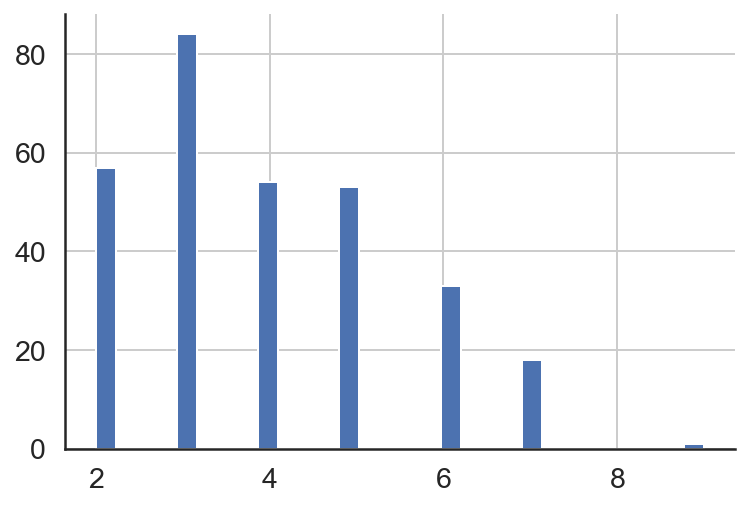

In [ ]:
ba = dp.get_ba_data(columns = ['redcap_event_name','mov_id','bx_aud_sum']).query("redcap_event_name=='erhebungszeitpunkt_arm_1'")
ba = ba[ba.mov_id.isin(initial_participants)]
aud = ba[~ba.bx_aud_sum.isnull()][['mov_id','bx_aud_sum']]
aud.columns = ['participant','aud']
aud = aud.groupby('participant').first()
aud.aud.hist(bins = 30)
sns.despine()

### Drinking days
16 participants did not report to drink any alcohol during the first EMA month.

In [ ]:
two_day = dp.get_two_day_data()
#drinking_days = two_day.query("sampling_day<30")#.groupby('participant').g_alc.agg(['mean','median'])
#drinking_days['drinking_days'] = ema_drinking.g_alc>0
#drinking_days = drinking_days.groupby('participant')[['g_alc','drinking_days']].sum().reset_index()
#drinking_days = drinking_days[drinking_days.participant.isin(initial_participants)].set_index('participant')

In [ ]:
tasks = pd.concat([wm, sst, rtt,ist],axis = 1).dropna()
tasks = tasks.loc[:,~tasks.columns.duplicated()]

In [ ]:
len(tasks.participant.unique())

274

In [ ]:
df = tasks.merge(dp.get_gbe_data(columns = ['trigger_date','time_since_last_gbe','ema_session']), on = 'gbe_index', how = 'left')

<AxesSubplot:>

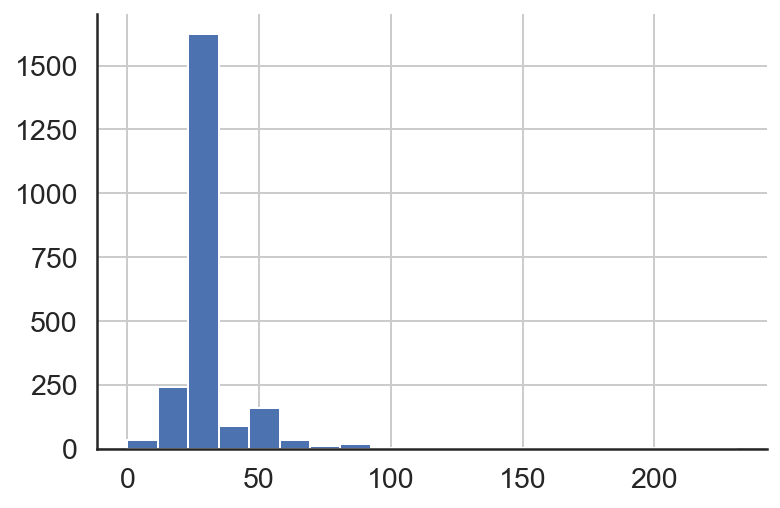

In [ ]:
df.time_since_last_gbe.hist(bins = 20)

> The distance between sessions is mostly 28 days. Some distances are longer (probably due to skipped sessions). Very few are, however also mach shorter.

In [ ]:
df['time_to_next_gbe'] = df.time_since_last_gbe.shift(-1)
# Send maximum to 28 days
df['time_to_next_gbe'][df['time_to_next_gbe'] >= 28] = 28
df.time_to_next_gbe.fillna(28,inplace = True)

> Here we use the distance to the next session or a maximum of 28 days as the window in which we will aggregate drinking data.

> ToDo: This function should be generalized to allow for other windows for exploratory analyses.

In [ ]:
df['end_date'] = df.trigger_date + pd.to_timedelta(df.time_to_next_gbe, unit = 'd')

In [ ]:
two_day['gbe_index'] = None
# Not pretty but it should work
for s in df[['trigger_date','end_date','participant']].reset_index().iterrows():
    gbe_index = s[1].loc['gbe_index']
    starting_date = s[1].loc['trigger_date']
    end_date = s[1].loc['end_date']
    participant = s[1].loc['participant']
    selection = two_day.query('(participant==@participant) and (date<@end_date) and (date >= @starting_date)').index
    two_day.loc[selection, 'gbe_index'] = gbe_index
    
print(end_date)

2021-08-30 15:47:07


In [ ]:
import numpy as np
two_day['drinking_days'] = two_day.g_alc>0
two_day['limit'] = two_day['limit']-1
drinking = two_day.groupby('gbe_index').agg({'g_alc':[np.mean, np.median, np.sum],'drinking_days':np.sum,'limit':[np.median], 'control':np.mean})
drinking.columns = ['_'.join(col).strip() for col in drinking.columns.values]
drinking.loc[drinking.g_alc_mean.isnull(), 'drinking_days_sum'] = np.nan
drinking['g_alc_per_drinking_day'] = drinking['g_alc_sum']/drinking['drinking_days_sum']
drinking = drinking[['g_alc_mean','g_alc_median','g_alc_per_drinking_day','limit_median','control_mean']]

## Task score correlations

In [ ]:
cor = pd.concat([drinking, tasks], axis = 1).dropna()
import biuR

def pearson_r(x, y, df):
    return scipy.stats.pearsonr(df[x], df[y])
    

#export
def lmer(x, y, df):    
    R = biuR.wrapper.R()
    p = R("""
    library(lmerTest)
    library(ggeffects)
    # Running the model
    control=lmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    m = lmer(%(y)s ~ %(x)s + (1 | participant), data=df, na.action = na.exclude) 
    estimate = summary(m)$coefficients[2]
    p_value = summary(m)$coefficients[10]
    """%{'x':x,'y':y},push=dict(df=df))
    
    
    m = R("""m""")
    estimate = R("""estimate""")
    p_value = R("""p_value""")

    return estimate[0], p_value[0]

lmer('wm_no_1','g_alc_mean',cor)

(-6.2146321320613, 0.09530903937780459)

In [ ]:
import scipy

def correl(df, corr_func = pearson_r):
    df_corr = pd.DataFrame() # Correlation matrix
    
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in df.drop(columns='participant').columns:
        for y in df.drop(columns='participant').columns:
            try:
                if x==y:
                    corr = (1,0)
                corr = corr_func(x, y, df)
                df_corr.loc[x,y] = corr[0]
                df_p.loc[x,y] = corr[1]
            except:
                df_corr.loc[x,y] = np.nan
                df_p.loc[x,y] = np.nan

    return df_corr, df_p

def correlation_matrix(analysis_data, alpha = .05, bonferroni = False, size = (11,9), show_correl = True, corr_func = pearson_r):
    print(len(analysis_data))

    if bonferroni:
        variables = len(analysis_data.columns)
        correction = ((variables * variables) - variables)/2
        alpha = alpha / correction

    df_corr, df_p = correl(analysis_data, corr_func = corr_func)
    
    #sig = (df_p < alpha).replace({True:"*",False:""})
    
    sig = df_p
    sig.where(sig>=.001).fillna(2)
    sig = sig.where(sig>=.01).fillna(3)
    sig = sig.where(sig>.05).fillna(4)
    sig = sig.where(sig>1).fillna(5)
    sig = sig.replace({2:"***"})
    sig = sig.replace({3:"**"})
    sig = sig.replace({4:"*"})
    sig = sig.replace({5:""})

    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    df_corr_label = df_corr.applymap(lambda x: ('%.2f'%x).replace('0.','.'))
    try:
        df_corr_label = df_corr_label + sig
    except:
        df_corr_label = "err"
    if show_correl:
        p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                   annot=df_corr_label,fmt = '')
    else:
         p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},fmt = '')       
    #p1.text(len(df_corr)-1, 1, "Alpha = %g"%alpha, size='medium', color='black')
    p = df_p.unstack()
    p.index = ['*'.join(map(str,i)) for i in p.index.tolist()]
    p = p.to_dict()
    corr = df_corr.unstack()
    corr.index = ['*'.join(map(str,i)) for i in corr.index.tolist()]
    corr = corr.to_dict()
    

In [ ]:
labels = {
    "wm_no_1":"no distractor (long)",
    "wm_no_2":"no distractor (short)",
    "wm_encoding":"encoding distractor",
    "wm_delayed":"delayed distractor",
    "rtt_win":"% gambles (win)",
    "rtt_loss":"% gambles (loss)",
    "rtt_mixed":"% gambles (mixed)",
    "ist_oversampling":"oversampling",
    "last_three_month":"Drinks per day",
    "g_alc_per_day_last_three_month":"g/alc per day",
    "g_alc_per_drinking_day_last_three_month":"g/alc per drinking day",
    "drinking_days_last_three_month":"Drinking days",
    "aud":"AUD criteria",
    "g_alc_mean":"Mean consumption",
    "g_alc_median":"Median consumption",
    "drinking_days":" Drinking days",
    "g_alc_per_drinking_day":" g/alc per drinking day"
}

next step: change window of drikning and beetter nan handling

### Based on mixed models
e.g., `g_alc_mean ~ ssrt + (1|participant)`

In [ ]:
from trr265.stats import decompose_within_between

1991


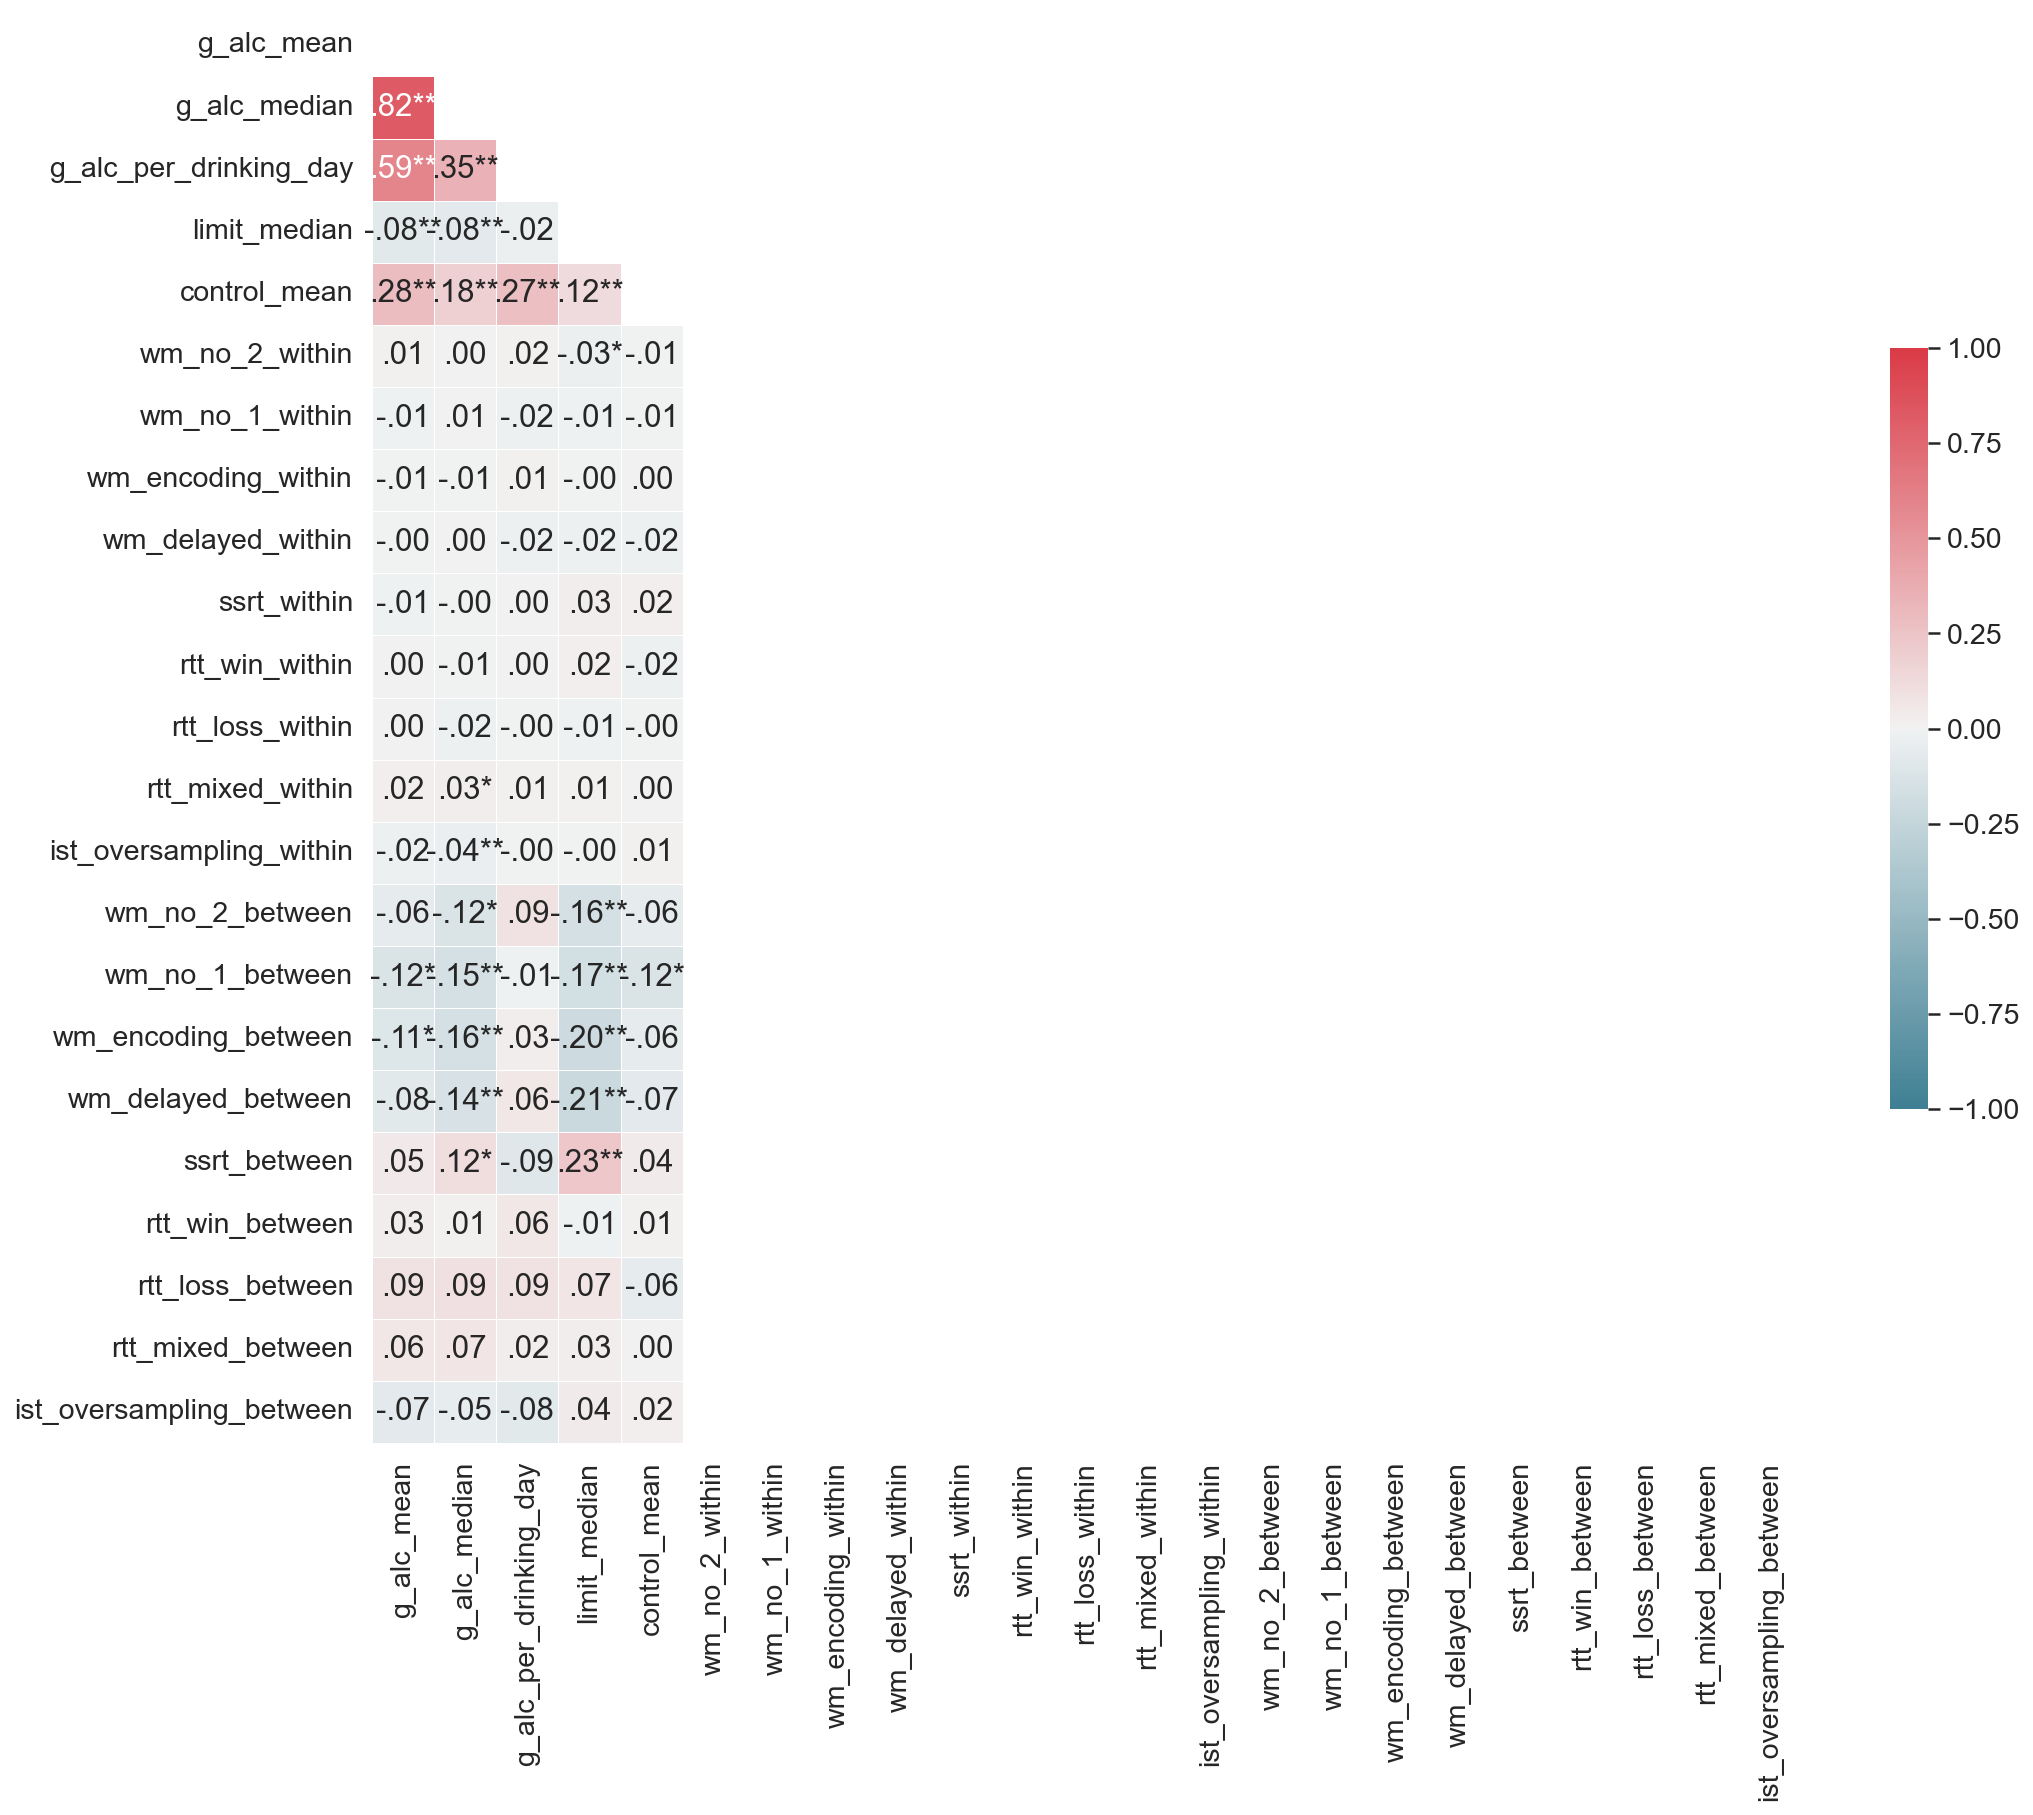

In [ ]:
cor = pd.concat([drinking, tasks], axis = 1).dropna()
columns = list(tasks.drop(columns = ['participant','session_number']))
cor = decompose_within_between(cor,columns = columns)
cor2 = cor.set_index('participant')
cor2 = (cor2-cor2.mean())/cor2.std()
correlation_matrix(cor2.drop(columns=['session_number']).reset_index(), corr_func = lmer_within_between, size = (16, 14))

#### Oversampling and consumption

In [ ]:
cor = pd.concat([drinking, tasks], axis = 1).dropna()
columns = list(tasks.drop(columns = ['participant','session_number']))
cor2_d = decompose_within_between(cor,columns = columns)
#cor2_d = cor.set_index('participant')
#cor2 = (cor2-cor2.mean())/cor2.std()

In [ ]:
lmer_within_between('ist_oversampling_within', 'g_alc_median',cor2.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_median ~ ist_oversampling_within + ist_oversampling_between +  
    (1 | participant)
   Data: df

REML criterion at convergence: 4040

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5429 -0.4073 -0.0765  0.3976  8.6600 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6502   0.8063  
 Residual                0.3102   0.5570  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                           Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)                -0.05939    0.05175  269.29060  -1.147  0.25220   
ist_oversampling_within    -0.03648    0.01249 1731.31583  -2.921  0.00353 **
ist_oversampling_between   -0.05016    0.05250  264.64843  -0.955  0.34031   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
               (Intr) ist_vrsmplng_w
ist_vr

(-0.03647661899183668, 0.003529529875043478)

<AxesSubplot:xlabel='ist_oversampling_within', ylabel='g_alc_median'>

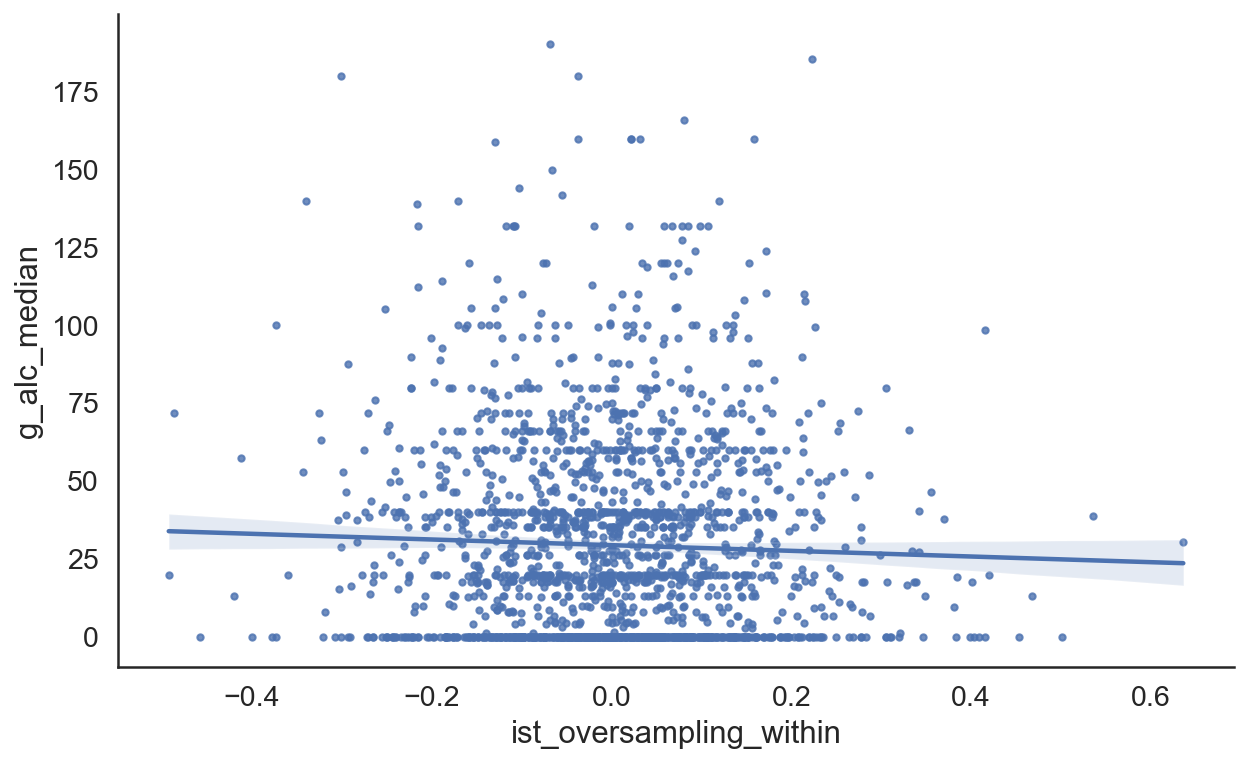

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'ist_oversampling_within', y = 'g_alc_median', data = cor2_d,scatter_kws={'s':10})

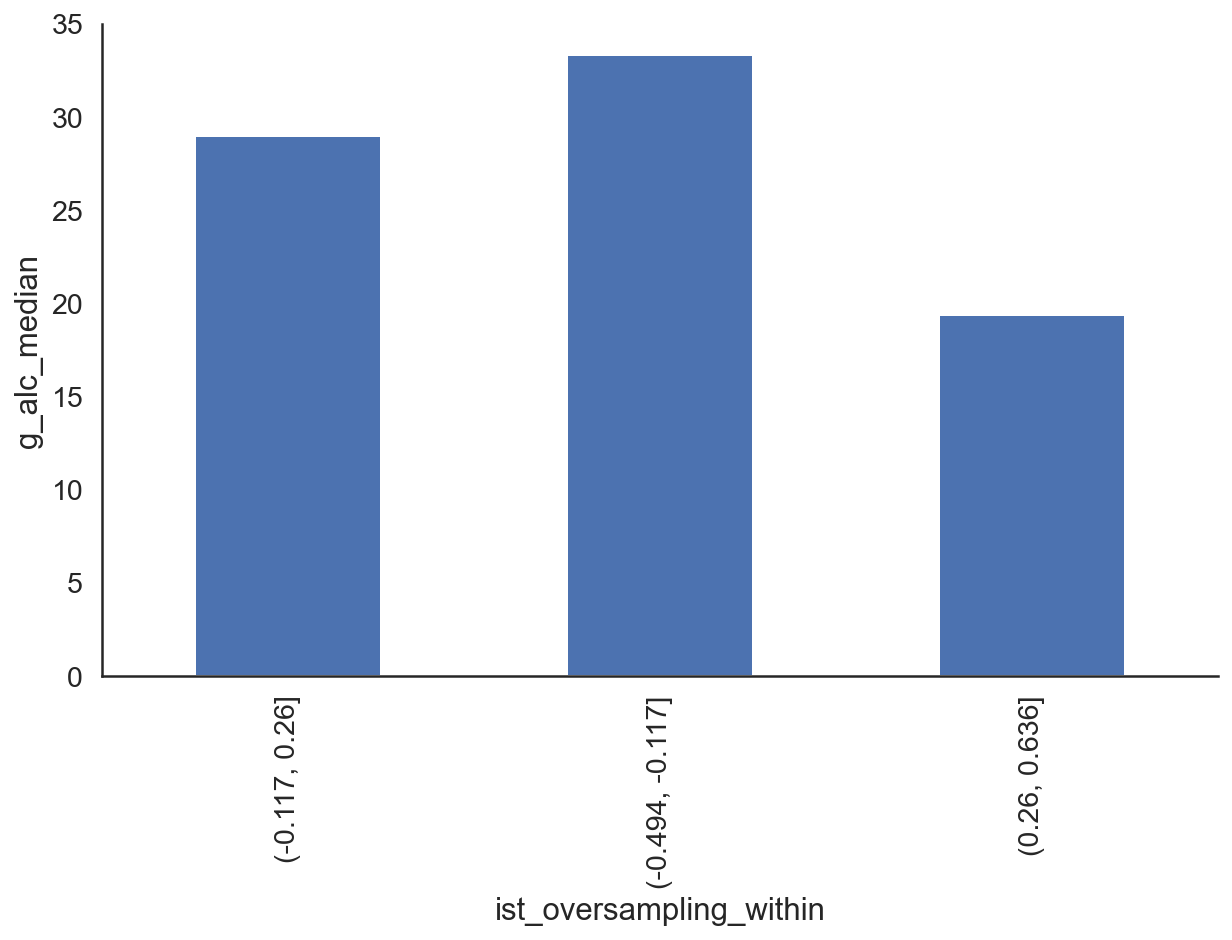

In [ ]:
def binned_plot(x,y,df,bins):
    df['x_binned'] = pd.cut(df[x], 3)
    df = df.sort_values('x_binned')
    df['x_binned'] = df.x_binned.astype(str)
    _df = df.groupby('x_binned')[y].agg([np.mean, np.std]).reset_index()
    ax = _df.plot.bar(x = 'x_binned', y = 'mean',figsize=(10,6), legend = False, sort_columns = False)
    #plt.bar(x)
    #plt.errorbar(df['x_binned'].astype(str), df[y], yerr = _df['std'],fmt='o',ecolor = 'red',color='yellow')
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    
binned_plot('ist_oversampling_within', 'g_alc_median', cor2_d, 3)

NameError: name 'x' is not defined

<Figure size 720x432 with 0 Axes>

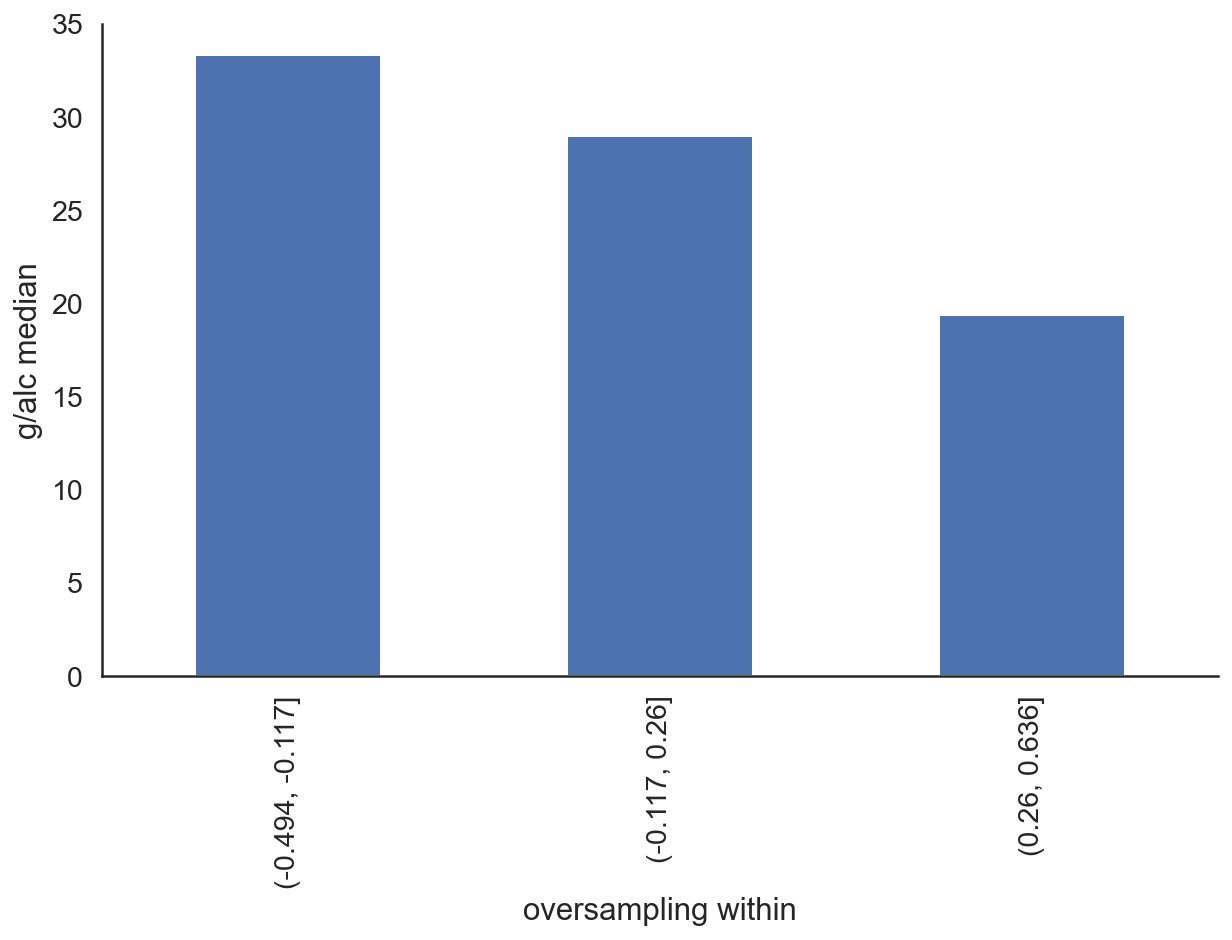

In [ ]:
plt.figure(figsize=(10,6))
cor2_d['limit_binned'] = pd.cut(cor2_d.ist_oversampling_within, 3)
ax = cor2_d.groupby('limit_binned').g_alc_median.agg([np.mean, np.std]).reset_index().plot.bar(x = 'limit_binned', y = 'mean',figsize=(10,6), legend = False)
ax.set_ylabel('g/alc median')
ax.set_xlabel('oversampling within')
plt.errorbar(x, y, yerr = y_error,fmt='o',ecolor = 'red',color='yellow')

#### WM no encoding (fast) and consumption

In [ ]:
lmer_within_between('wm_no_2_within', 'g_alc_median',cor2.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_median ~ wm_no_2_within + wm_no_2_between + (1 | participant)
   Data: df

REML criterion at convergence: 4043.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5573 -0.3978 -0.0786  0.4194  8.6738 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6381   0.7988  
 Residual                0.3117   0.5583  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)     -6.216e-02  5.134e-02  2.702e+02  -1.211   0.2270  
wm_no_2_within   4.216e-03  1.251e-02  1.732e+03   0.337   0.7362  
wm_no_2_between -1.206e-01  4.961e-02  2.730e+02  -2.431   0.0157 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) wm_n_2_w
wm_n_2_wthn 0.000          
wm_n_2_btwn 0.024  0.000   


(0.0042159362065437795, 0.7362439827033542)

<AxesSubplot:xlabel='wm_no_2_between', ylabel='g_alc_median'>

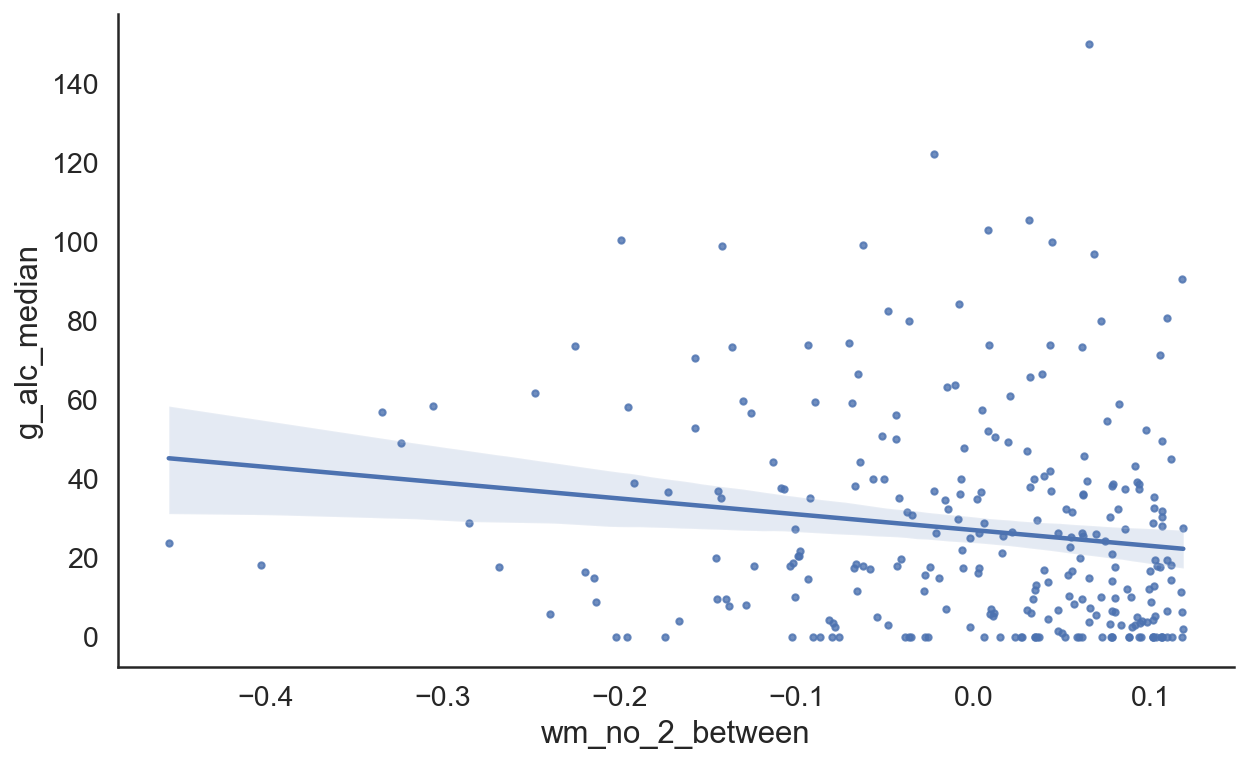

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'wm_no_2_between', y = 'g_alc_median', data = cor2_d.groupby('participant').mean(),scatter_kws={'s':10})

#### WM encoding and consumption

In [ ]:
lmer_within_between('wm_encoding_within', 'g_alc_median',cor2.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_median ~ wm_encoding_within + wm_encoding_between + (1 |  
    participant)
   Data: df

REML criterion at convergence: 4038.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5351 -0.3952 -0.0774  0.4147  8.6697 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6259   0.7911  
 Residual                0.3115   0.5581  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                      Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         -6.349e-02  5.089e-02  2.709e+02  -1.248 0.213252    
wm_encoding_within  -7.167e-03  1.251e-02  1.733e+03  -0.573 0.566818    
wm_encoding_between -1.639e-01  4.897e-02  2.733e+02  -3.347 0.000933 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) wm_ncdng_w
wm_ncdng_wt 0.000            
wm_ncdn

(-0.007167494961998365, 0.5668181000797892)

<AxesSubplot:xlabel='wm_encoding_between', ylabel='g_alc_median'>

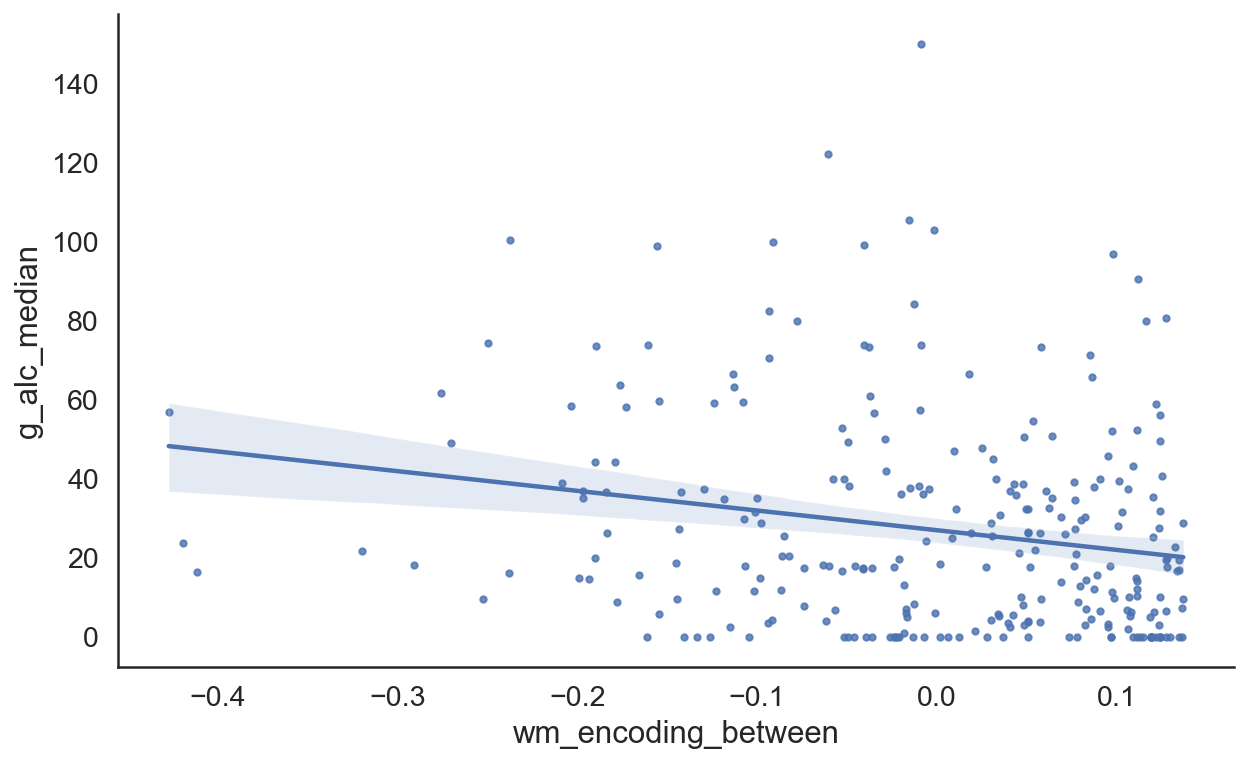

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'wm_encoding_between', y = 'g_alc_median', data = cor2_d.groupby('participant').mean(),scatter_kws={'s':10})

#### WM delayed encoding and consumption

In [ ]:
lmer_within_between('wm_delayed_within', 'g_alc_median',cor2.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_median ~ wm_delayed_within + wm_delayed_between + (1 |  
    participant)
   Data: df

REML criterion at convergence: 4042.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5553 -0.3965 -0.0809  0.4178  8.6879 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6340   0.7962  
 Residual                0.3117   0.5583  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                     Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)        -6.069e-02  5.117e-02  2.697e+02  -1.186  0.23665   
wm_delayed_within   3.484e-04  1.252e-02  1.732e+03   0.028  0.97780   
wm_delayed_between -1.364e-01  5.088e-02  2.679e+02  -2.680  0.00782 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) wm_dlyd_w
wm_dlyd_wth 0.000           
wm_dlyd_btw 0.012  

(0.0003483519752244682, 0.9777989074939504)

<AxesSubplot:xlabel='wm_delayed_between', ylabel='g_alc_median'>

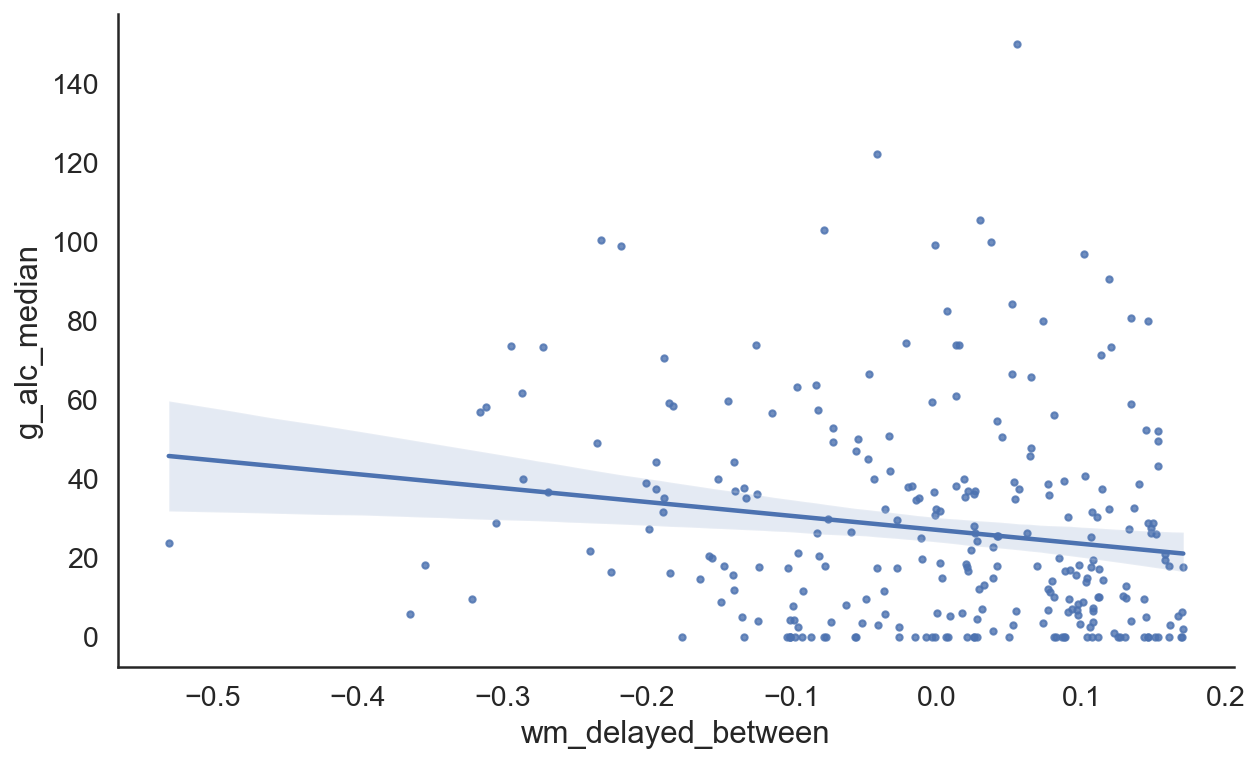

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'wm_delayed_between', y = 'g_alc_median', data = cor2_d.groupby('participant').mean(),scatter_kws={'s':10})

#### SSRT and consumption

In [ ]:
lmer_within_between('ssrt_within', 'g_alc_median',cor2.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_median ~ ssrt_within + ssrt_between + (1 | participant)
   Data: df

REML criterion at convergence: 4044

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5528 -0.4017 -0.0683  0.4172  8.6698 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6364   0.7978  
 Residual                0.3118   0.5584  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)  -6.454e-02  5.131e-02  2.684e+02  -1.258   0.2095  
ssrt_within  -6.789e-04  1.252e-02  1.731e+03  -0.054   0.9568  
ssrt_between  1.159e-01  4.865e-02  2.796e+02   2.383   0.0178 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) ssrt_w
ssrt_within  0.000       
ssrt_betwen -0.044  0.000


(-0.0006789280940398106, 0.9567531501065042)

<AxesSubplot:xlabel='ssrt_between', ylabel='g_alc_median'>

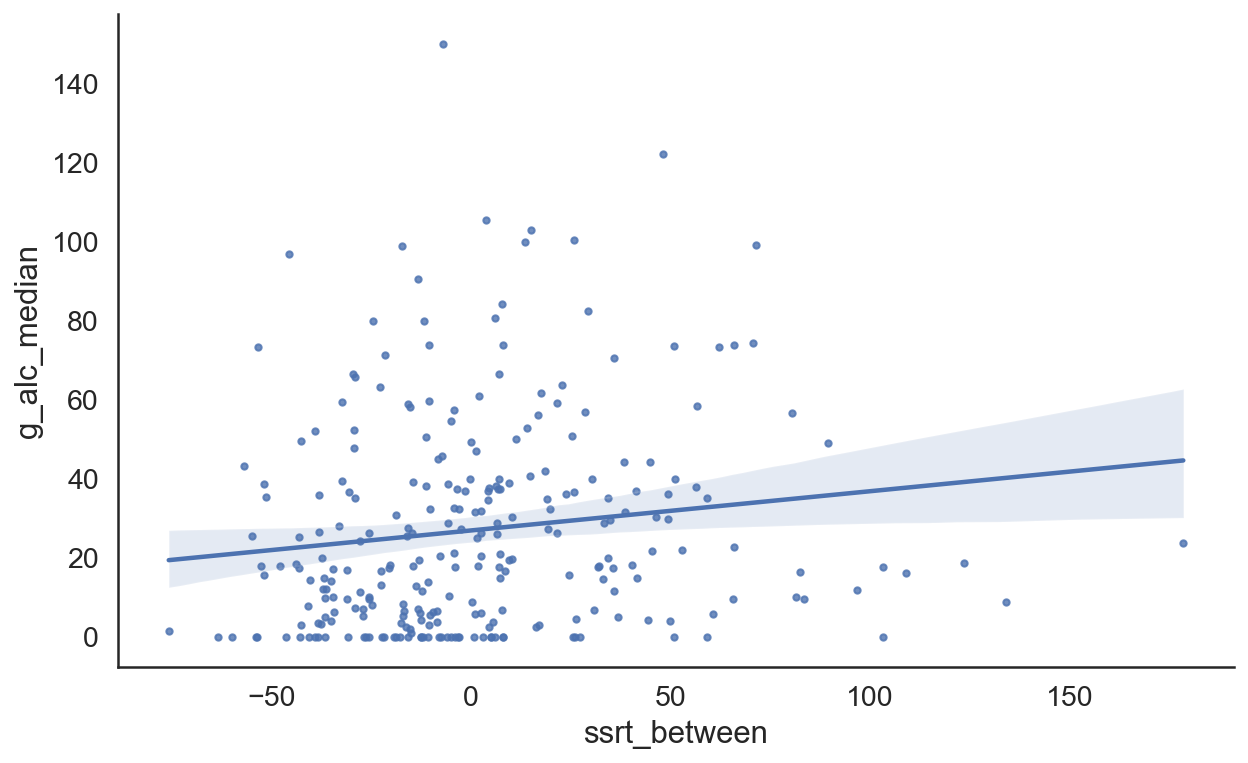

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'ssrt_between', y = 'g_alc_median', data = cor2_d.groupby('participant').mean(),scatter_kws={'s':10})

#### SSRT and loss of control

In [ ]:
lmer_within_between('ssrt_within', 'control_mean',cor2.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: control_mean ~ ssrt_within + ssrt_between + (1 | participant)
   Data: df

REML criterion at convergence: 4033.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9531 -0.4638 -0.0956  0.3979  4.8364 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6743   0.8211  
 Residual                0.3076   0.5546  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)
(Intercept)  6.884e-03  5.266e-02 2.659e+02   0.131    0.896
ssrt_within  1.748e-02  1.243e-02 1.728e+03   1.406    0.160
ssrt_between 4.442e-02  4.990e-02 2.764e+02   0.890    0.374

Correlation of Fixed Effects:
            (Intr) ssrt_w
ssrt_within  0.000       
ssrt_betwen -0.045  0.000


(0.017477497558419566, 0.1599514405756256)

<AxesSubplot:xlabel='ssrt_within', ylabel='control_mean'>

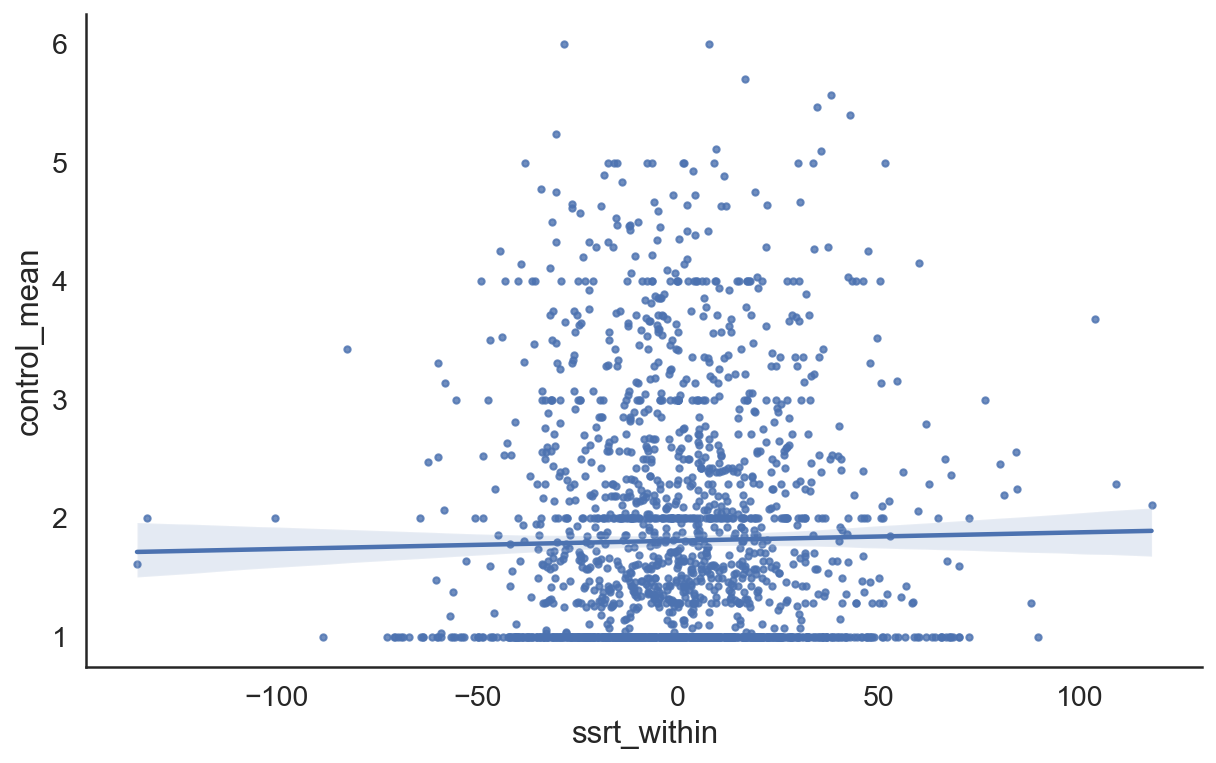

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'ssrt_within', y = 'control_mean', data = cor2_d,scatter_kws={'s':10})

Text(0.5, 0, 'SSRT within')

<Figure size 720x432 with 0 Axes>

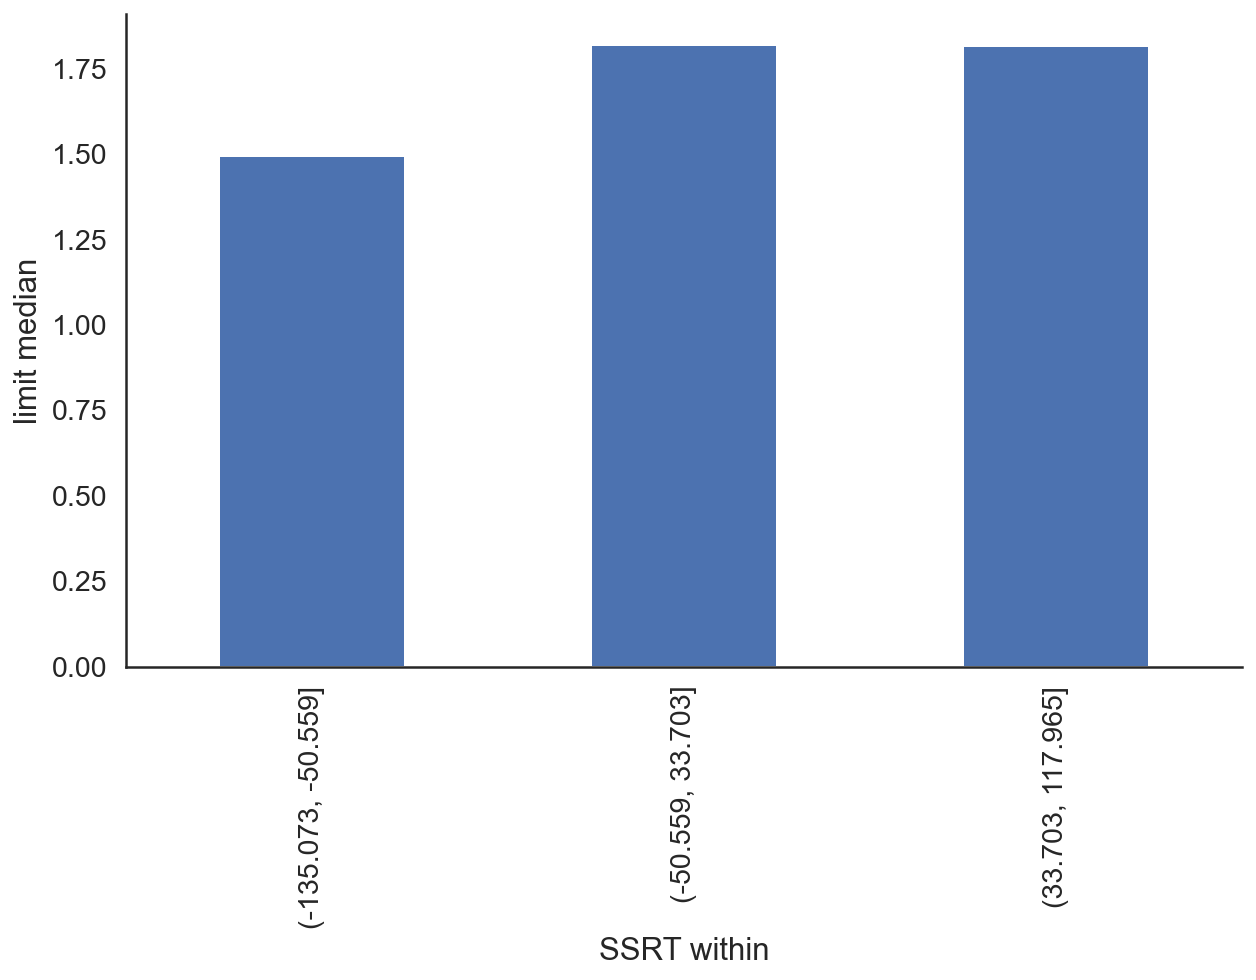

In [ ]:
plt.figure(figsize=(10,6))
cor2_d['limit_binned'] = pd.cut(cor2_d.ssrt_within, 3)
ax = cor2_d.groupby('limit_binned').control_mean.agg([np.mean, np.std]).reset_index().plot.bar(x = 'limit_binned', y = 'mean',figsize=(10,6), legend = False)
ax.set_ylabel('limit median')
ax.set_xlabel('SSRT within')


In [ ]:
cor2 = pd.concat([drinking, factor_scores.set_index('gbe_index')[['participant','Factor_1','Factor_2','Factor_3']]], axis = 1).dropna()
cor3 = cor2.set_index('participant')
columns = ['limit_mean','limit_median','control_mean','Factor_1','Factor_2','Factor_3']
cor4 = decompose_within_between(cor3.reset_index(),columns = columns)

NameError: name 'factor_scores' is not defined

1991


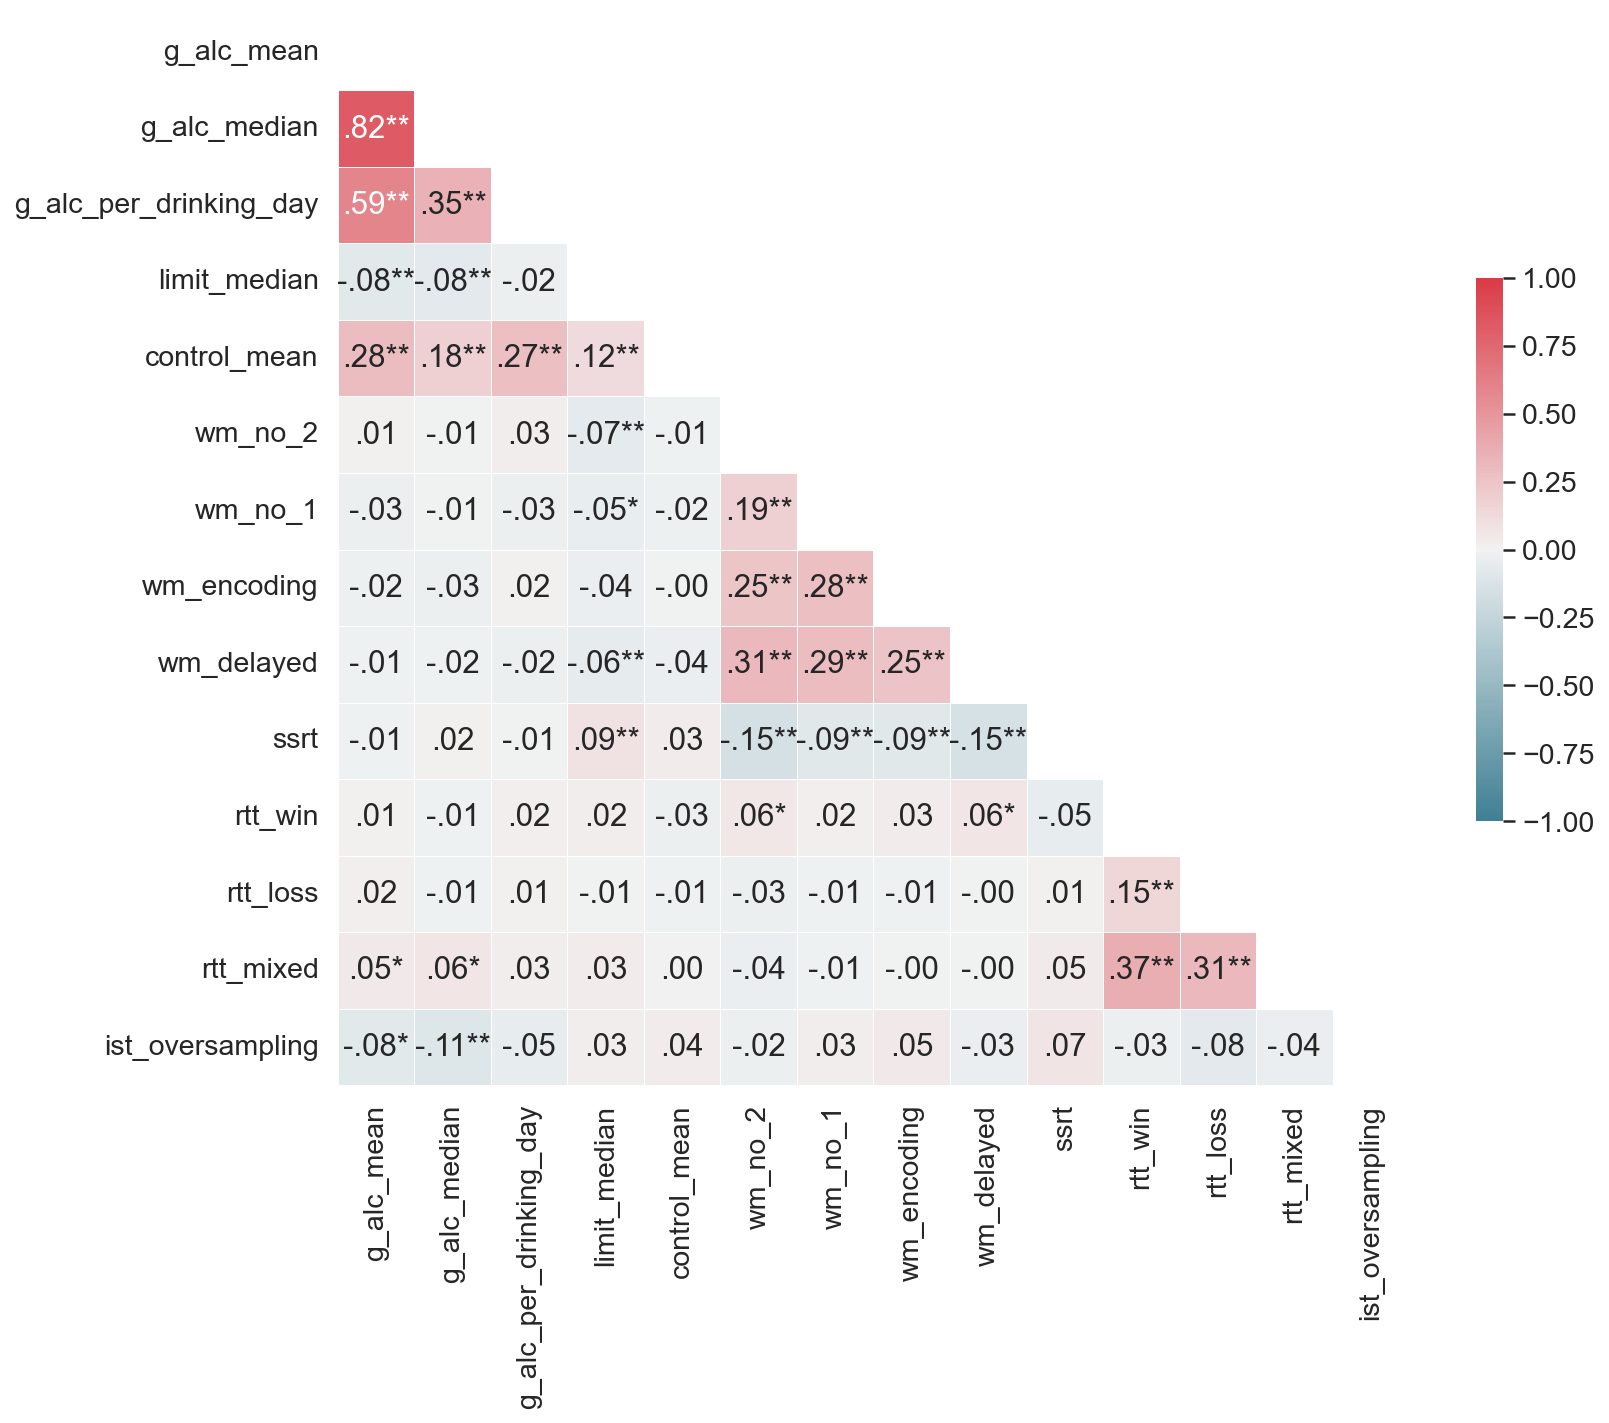

In [ ]:
cor = pd.concat([drinking, tasks], axis = 1).dropna()
cor2 = cor.set_index('participant')
cor2 = (cor2-cor2.mean())/cor2.std()
correlation_matrix(cor2.reset_index().drop(columns = ['session_number']), corr_func = lmer, size = (12, 10))

In [ ]:
cor.limit_median.value_counts()

0.0    970
1.0    527
2.0    478
1.5     11
0.5      5
Name: limit_median, dtype: int64

#### Intention and drinking

In [ ]:
%%R -i cor
require(lmer)
m <- lmer(wm_no_2 ~ as.factor(limit_median) + (1|participant), data = cor)
summary(m)

R[write to console]: Lade nötiges Paket: lmer



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: wm_no_2 ~ as.factor(limit_median) + (1 | participant)
   Data: cor

REML criterion at convergence: -3377.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5784 -0.4522  0.2020  0.5269  2.8939 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.008881 0.09424 
 Residual                0.007989 0.08938 
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 8.805e-01  7.012e-03  3.782e+02 125.577  < 2e-16
as.factor(limit_median)0.5 -7.461e-03  4.272e-02  1.790e+03  -0.175  0.86139
as.factor(limit_median)1   -1.170e-02  7.000e-03  1.986e+03  -1.671  0.09485
as.factor(limit_median)1.5 -3.231e-02  2.938e-02  1.830e+03  -1.100  0.27157
as.factor(limit_median)2   -2.286e-02  7.323e-03  1.982e+03  -3.122  0.00182
                         

#### intention as factor

In [ ]:
%%R -i cor
require(lmer)
m <- lmer(wm_no_2 ~ as.factor(limit_median) + (1|participant), data = cor)
summary(m)

R[write to console]: Lade nötiges Paket: lmer



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: wm_no_2 ~ as.factor(limit_median) + (1 | participant)
   Data: cor

REML criterion at convergence: -3377.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5784 -0.4522  0.2020  0.5269  2.8939 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.008881 0.09424 
 Residual                0.007989 0.08938 
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 8.805e-01  7.012e-03  3.782e+02 125.577  < 2e-16
as.factor(limit_median)0.5 -7.461e-03  4.272e-02  1.790e+03  -0.175  0.86139
as.factor(limit_median)1   -1.170e-02  7.000e-03  1.986e+03  -1.671  0.09485
as.factor(limit_median)1.5 -3.231e-02  2.938e-02  1.830e+03  -1.100  0.27157
as.factor(limit_median)2   -2.286e-02  7.323e-03  1.982e+03  -3.122  0.00182
                         

### Cross-sectional effects based on longitudinal data

267


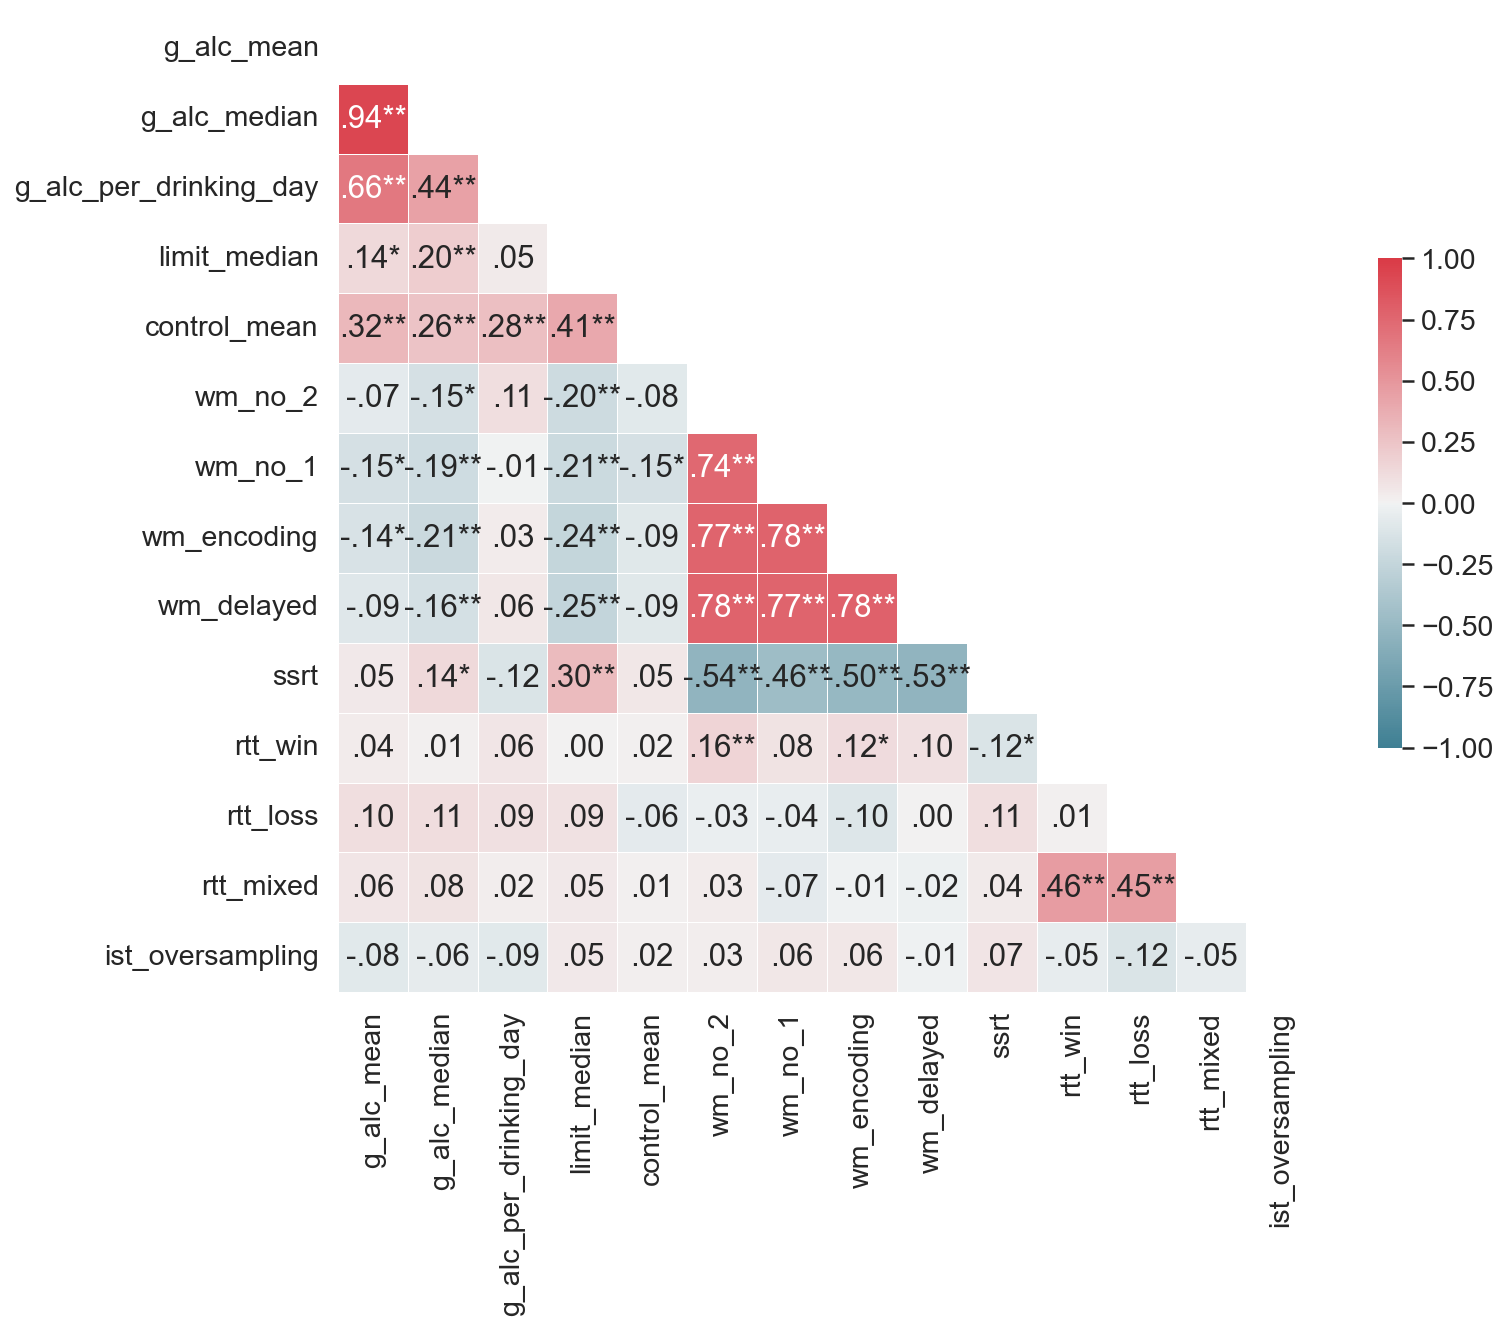

In [ ]:
correlation_matrix(cor.groupby('participant').mean().reset_index().drop(columns = ['session_number']))

### Average longitudinal correlation per participant

In [ ]:
pps = cor.participant.unique()

In [ ]:
cor.groupby('participant').corr().reset_index().groupby('level_1').mean()

,g_alc_mean,g_alc_median,g_alc_per_drinking_day,limit_median,control_mean,wm_no_2,wm_no_1,wm_encoding,wm_delayed,session_number,ssrt,rtt_win,rtt_loss,rtt_mixed,ist_oversampling
level_1,,,,,,,,,,,,,,,
control_mean,0.261466,0.173212,0.240331,0.100301,1.000000,-0.004796,-0.010948,-0.002363,-0.093745,-0.101633,0.011670,-0.024263,0.040399,-0.019387,0.070425
g_alc_mean,1.000000,0.793815,0.600697,-0.121828,0.261466,0.033871,-0.001946,-0.027654,-0.038035,-0.042065,0.031542,0.009276,0.003581,0.046664,0.023158
g_alc_median,0.793815,1.000000,0.350641,-0.118363,0.173212,0.000361,0.054282,-0.044143,-0.029609,-0.022113,0.021391,-0.002266,-0.031966,0.062892,-0.005453
g_alc_per_drinking_day,0.600697,0.350641,1.000000,-0.005903,0.240331,0.008677,-0.045455,0.006059,-0.042934,-0.059388,0.023992,0.007913,-0.032784,0.032572,0.004251
ist_oversampling,0.023158,-0.005453,0.004251,-0.000823,0.070425,-0.005536,0.016746,0.001009,-0.041072,-0.151763,0.016893,0.007483,-0.004127,-0.029025,1.000000
limit_median,-0.121828,-0.118363,-0.005903,1.000000,0.100301,-0.083142,-0.038642,-0.006127,-0.052651,-0.087837,0.055684,0.009408,0.000676,0.029503,-0.000823
rtt_loss,0.003581,-0.031966,-0.032784,0.000676,0.040399,-0.047919,0.004417,-0.028223,-0.032236,-0.051459,-0.039838,0.088903,1.000000,0.188637,-0.004127
rtt_mixed,0.046664,0.062892,0.032572,0.029503,-0.019387,-0.068081,0.018926,-0.019964,0.011311,-0.064748,0.035263,0.190802,0.188637,1.000000,-0.029025
rtt_win,0.009276,-0.002266,0.007913,0.009408,-0.024263,0.033255,0.029494,0.014486,0.064901,0.000014,-0.026764,1.000000,0.088903,0.190802,0.007483


In [ ]:
cor.groupby('participant').corr().drop(columns=['session_number']).unstack()[['Mean consumption','Median consumption']].hist(figsize=(12,48), layout = (12,2), sharex=True);

KeyError: "['Mean consumption' 'Median consumption'] not in index"

## Factor score correlations

In [ ]:
factor_loadings = np.array([[ 7.92661829e-01,  4.78790772e-02,  4.86401575e-03],
       [ 7.63220032e-01, -1.40617072e-02,  3.25907524e-04],
       [ 7.49311048e-01, -2.53512341e-02, -1.37956558e-02],
       [ 8.18257813e-01,  1.04559605e-02, -9.31641296e-03],
       [ 4.63416842e-01, -7.38915150e-02,  1.43192654e-01],
       [ 1.79143311e-02, -2.67090047e-02,  8.60738590e-01],
       [ 7.90922395e-03,  9.98916460e-01, -1.35399086e-02],
       [-1.02745794e-01,  3.35920712e-01,  3.78108731e-01],
       [-7.42983269e-02, -1.32799950e-01, -6.17402248e-02]])

In [ ]:
import warnings
import numpy as np
from sklearn.preprocessing import scale

def matrix_sqrt(x):
    """
    Compute the square root of the eigen values (eVal),
    and then take $eVec * diag(eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    evals[evals < 0] = np.finfo(float).eps
    sqrt_evals = np.sqrt(evals)
    return evecs.dot(np.diag(sqrt_evals)).dot(evecs.T)


def inv_matrix_sqrt(x):
    """
    Compute the inverse square root of the eigen values (eVal),
    and then take $eVec * diag(1 / eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    if np.iscomplex(evals).any():
        warnings.warn('Complex eigen values detected; results are suspect.')
        return x
    evals[evals < np.finfo(float).eps] = 100 * np.finfo(float).eps
    inv_sqrt_evals =  1 / np.sqrt(evals)
    return evecs.dot(np.diag(inv_sqrt_evals)).dot(evecs.T)


def ten_berge(X, loadings, phi=None):
    """
    Estimate factor scores using the "ten Berge" method.

    Parameters
    ----------
    X : array-like
        The data set
    loadings : array-like
        The loadings matrix

    Reference
    ----------
    https://www.sciencedirect.com/science/article/pii/S0024379597100076
    """
    # get the number of factors from the loadings
    n_factors = loadings.shape[1]
    corr = np.corrcoef(X, rowvar=False)
    # if `phi` is None, create a diagonal matrix
    phi = np.diag(np.ones(n_factors)) if phi is None else phi
    # calculate intermediate metrics
    load = loadings.dot(matrix_sqrt(phi))
    corr_inv = inv_matrix_sqrt(corr)
    temp = corr_inv.dot(load)\
                   .dot(inv_matrix_sqrt(load.T.dot(np.linalg.inv(corr))
                                              .dot(load)))
    # calcualte weights
    weights = corr_inv.dot(temp)\
                      .dot(matrix_sqrt(phi))
    # calculate scores, given weights
    scores = scale(X).dot(weights)
    return scores

In [ ]:
tasks_session = tasks.set_index(['participant','session_number'])
tasks_session['ssrt'] = -tasks_session.ssrt

In [ ]:
import pickle
with open('../data/interim/fa.pkl', 'rb') as f:
    fa = pickle.load(f)

In [ ]:
factor_scores = pd.DataFrame(ten_berge(tasks_session, fa.loadings_))
factor_scores.columns = ['Factor_1','Factor_2','Factor_3']
factor_scores = pd.concat([tasks_session.reset_index(),factor_scores],axis = 1)
factor_scores['gbe_index'] = factor_scores.participant + '_' + factor_scores.session_number.apply(lambda x: '%03d'%int(x))

In [ ]:
factor_scores

,participant,session_number,wm_no_2,wm_no_1,wm_encoding,wm_delayed,ssrt,rtt_win,rtt_loss,rtt_mixed,ist_oversampling,Factor_1,Factor_2,Factor_3,gbe_index
0,b001,3.0,0.901783,0.913540,0.981140,0.970788,-334.965298,0.233080,0.656074,0.193606,0.247006,0.853037,0.835712,-1.396638,b001_003
1,b001,7.0,0.968729,0.976694,0.981140,0.970788,-308.747529,0.233080,0.184287,0.328255,0.403552,1.047353,-0.868656,-1.227780,b001_007
2,b001,9.0,0.858903,0.976694,0.981140,0.970788,-368.181926,0.233080,0.127197,0.193606,0.501393,0.738944,-1.065353,-1.434380,b001_009
3,b001,11.0,0.858903,0.976694,0.981140,0.970788,-354.732464,0.663045,0.127197,0.193606,0.501393,0.752262,-1.077040,-0.002059,b001_011
4,b001,12.0,0.968729,0.871100,0.881358,0.873498,-355.124973,0.373294,0.184287,0.401692,0.364416,0.323823,-0.806664,-0.837047,b001_012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224,m290,5.0,0.736448,0.951793,0.956992,0.812816,-444.728309,0.849122,0.686716,0.706454,-1.019708,-0.139819,0.886626,0.524770,m290_005
2225,m290,6.0,0.785920,0.951793,0.956992,0.669176,-323.390101,0.217077,0.099233,0.559915,-1.039277,-0.163938,-1.122164,-1.011390,m290_006
2226,m290,10.0,0.833585,0.827728,0.686491,0.933216,-337.245555,0.784975,0.411288,0.559915,-1.039277,-0.188715,-0.096037,0.731455,m290_010
2227,m290,4.0,0.736448,0.827728,0.835930,0.933216,-341.300497,0.217077,0.212119,0.335172,-0.980572,-0.102720,-0.764418,-1.208722,m290_004


2229


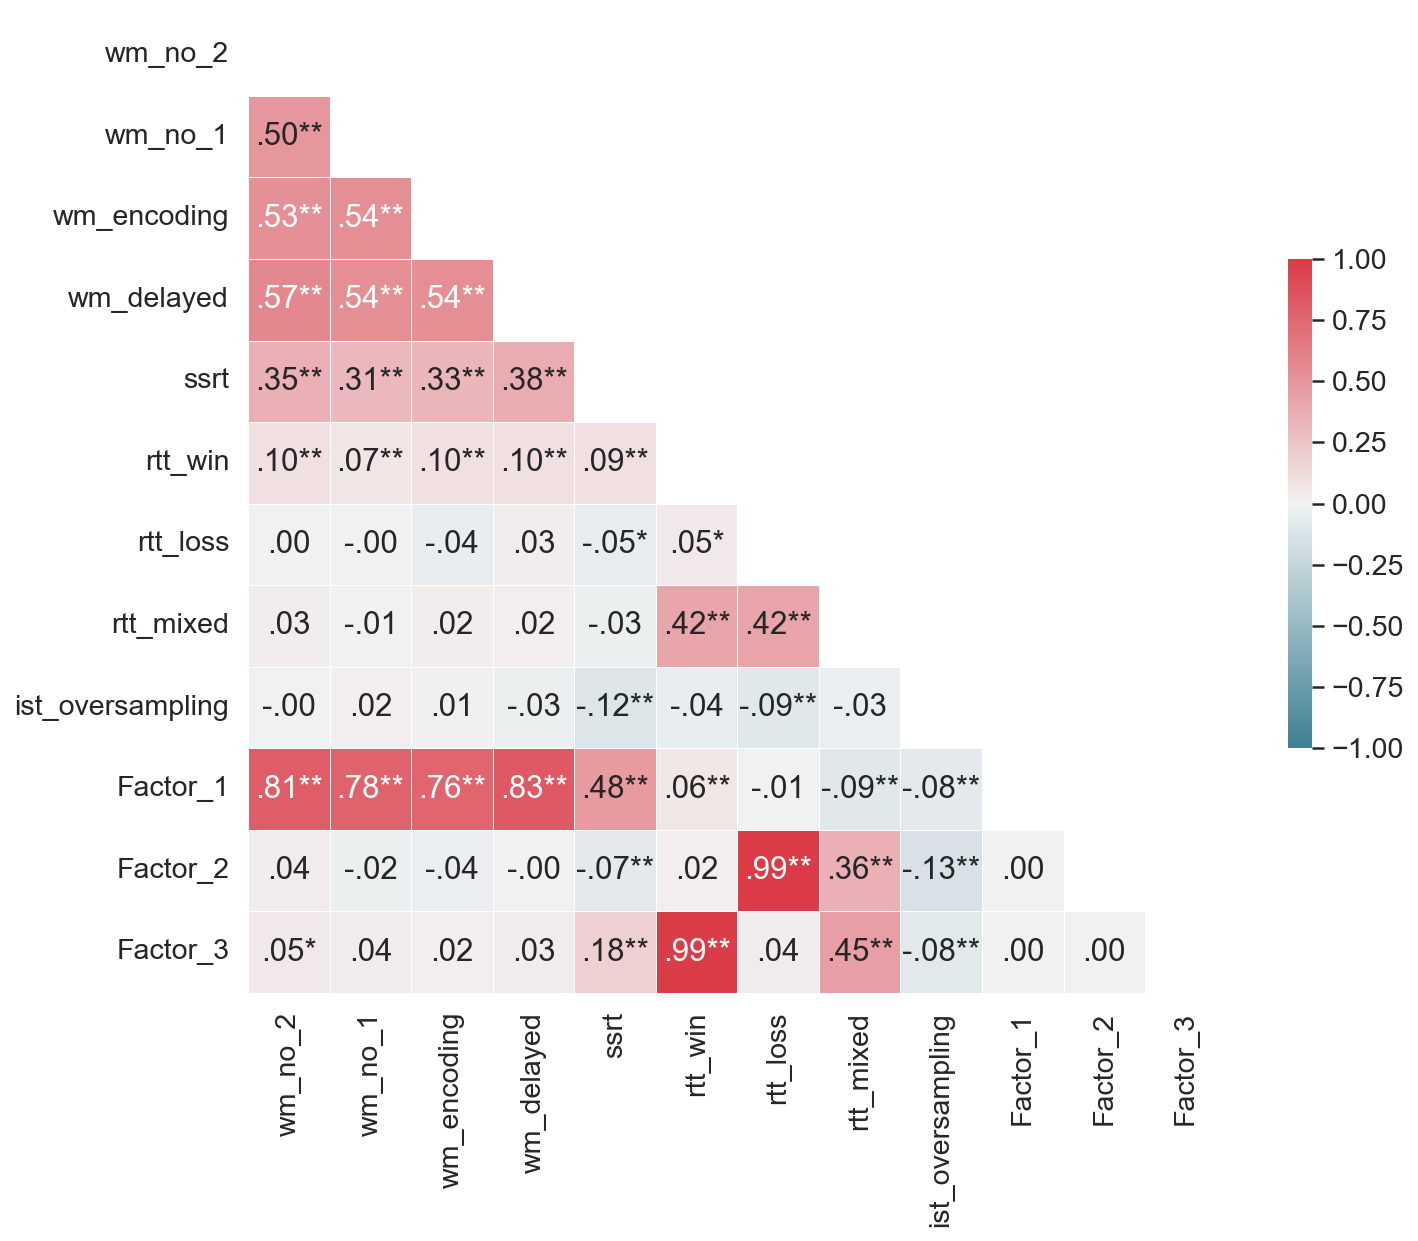

In [ ]:
correlation_matrix(factor_scores.drop(columns = ['session_number','gbe_index']))

### Based on mixed models

In [ ]:
from trr265.stats import decompose_within_between

In [ ]:
cor2 = pd.concat([drinking, factor_scores.set_index('gbe_index')[['participant','Factor_1','Factor_2','Factor_3']]], axis = 1).dropna()
cor3 = cor2.set_index('participant')
columns = ['limit_mean','limit_median','control_mean','Factor_1','Factor_2','Factor_3']
cor4 = decompose_within_between(cor3.reset_index(),columns = columns)


KeyError: "Columns not found: 'limit_mean'"

In [ ]:
def lmer_within_between(x, y, df, model_output = False): 
    if '_'.join(x.split('_')[:-1]) == y:
        return np.nan, np.nan
                
    if ('within' in x+y) and ('between' in x+y):
        return np.nan,np.nan # These should be nan
    if ('between' in y) or('within' in y):
        return np.nan,np.nan
    if 'within' in x:
        x_control = '_'.join(x.split('_')[:-1])+'_between'
    #elif 'between' in x:
    #    return np.nan, np.nan
        #x_control = '_'.join(x.split('_')[:-1])+'_within'
    else:
        return lmer(x,y,df)
    
    if model_output:
        model_output = 'print(summary(m))'
    else:
        model_output = ''

    
    R = biuR.wrapper.R()
    p = R("""
    library(lmerTest)
    library(ggeffects)
    # Running the model
    control=lmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    m = lmer(%(y)s ~ %(x)s + %(x_control)s + (1 | participant), data=df, na.action = na.exclude) 
    %(model_output)s
    estimate = summary(m)$coefficients[2]
    p_value = summary(m)$coefficients[14]
    """%{'x':x,'x_control':x_control,'y':y,'model_output':model_output},push=dict(df=df))
    
    
    m = R("""m""")
    estimate = R("""estimate""")
    p_value = R("""p_value""")

    return estimate[0], p_value[0]
         


In [ ]:
lmer_within_between('Factor_1_within','g_alc_mean', cor4, model_output=True)

NameError: name 'cor4' is not defined

In [ ]:
def lmer(x, y, df):    
    R = biuR.wrapper.R()
    p = R("""
    library(lmerTest)
    library(ggeffects)
    # Running the model
    control=lmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    m = lmer(%(y)s ~ %(x)s + (1 | participant), data=df, na.action = na.exclude) 
    estimate = summary(m)$coefficients[2]
    p_value = summary(m)$coefficients[10]
    """%{'x':x,'y':y},push=dict(df=df))
    
    
    m = R("""m""")
    estimate = R("""estimate""")
    p_value = R("""p_value""")

    return estimate[0], p_value[0]

In [ ]:
from trr265.stats import decompose_within_between

1991


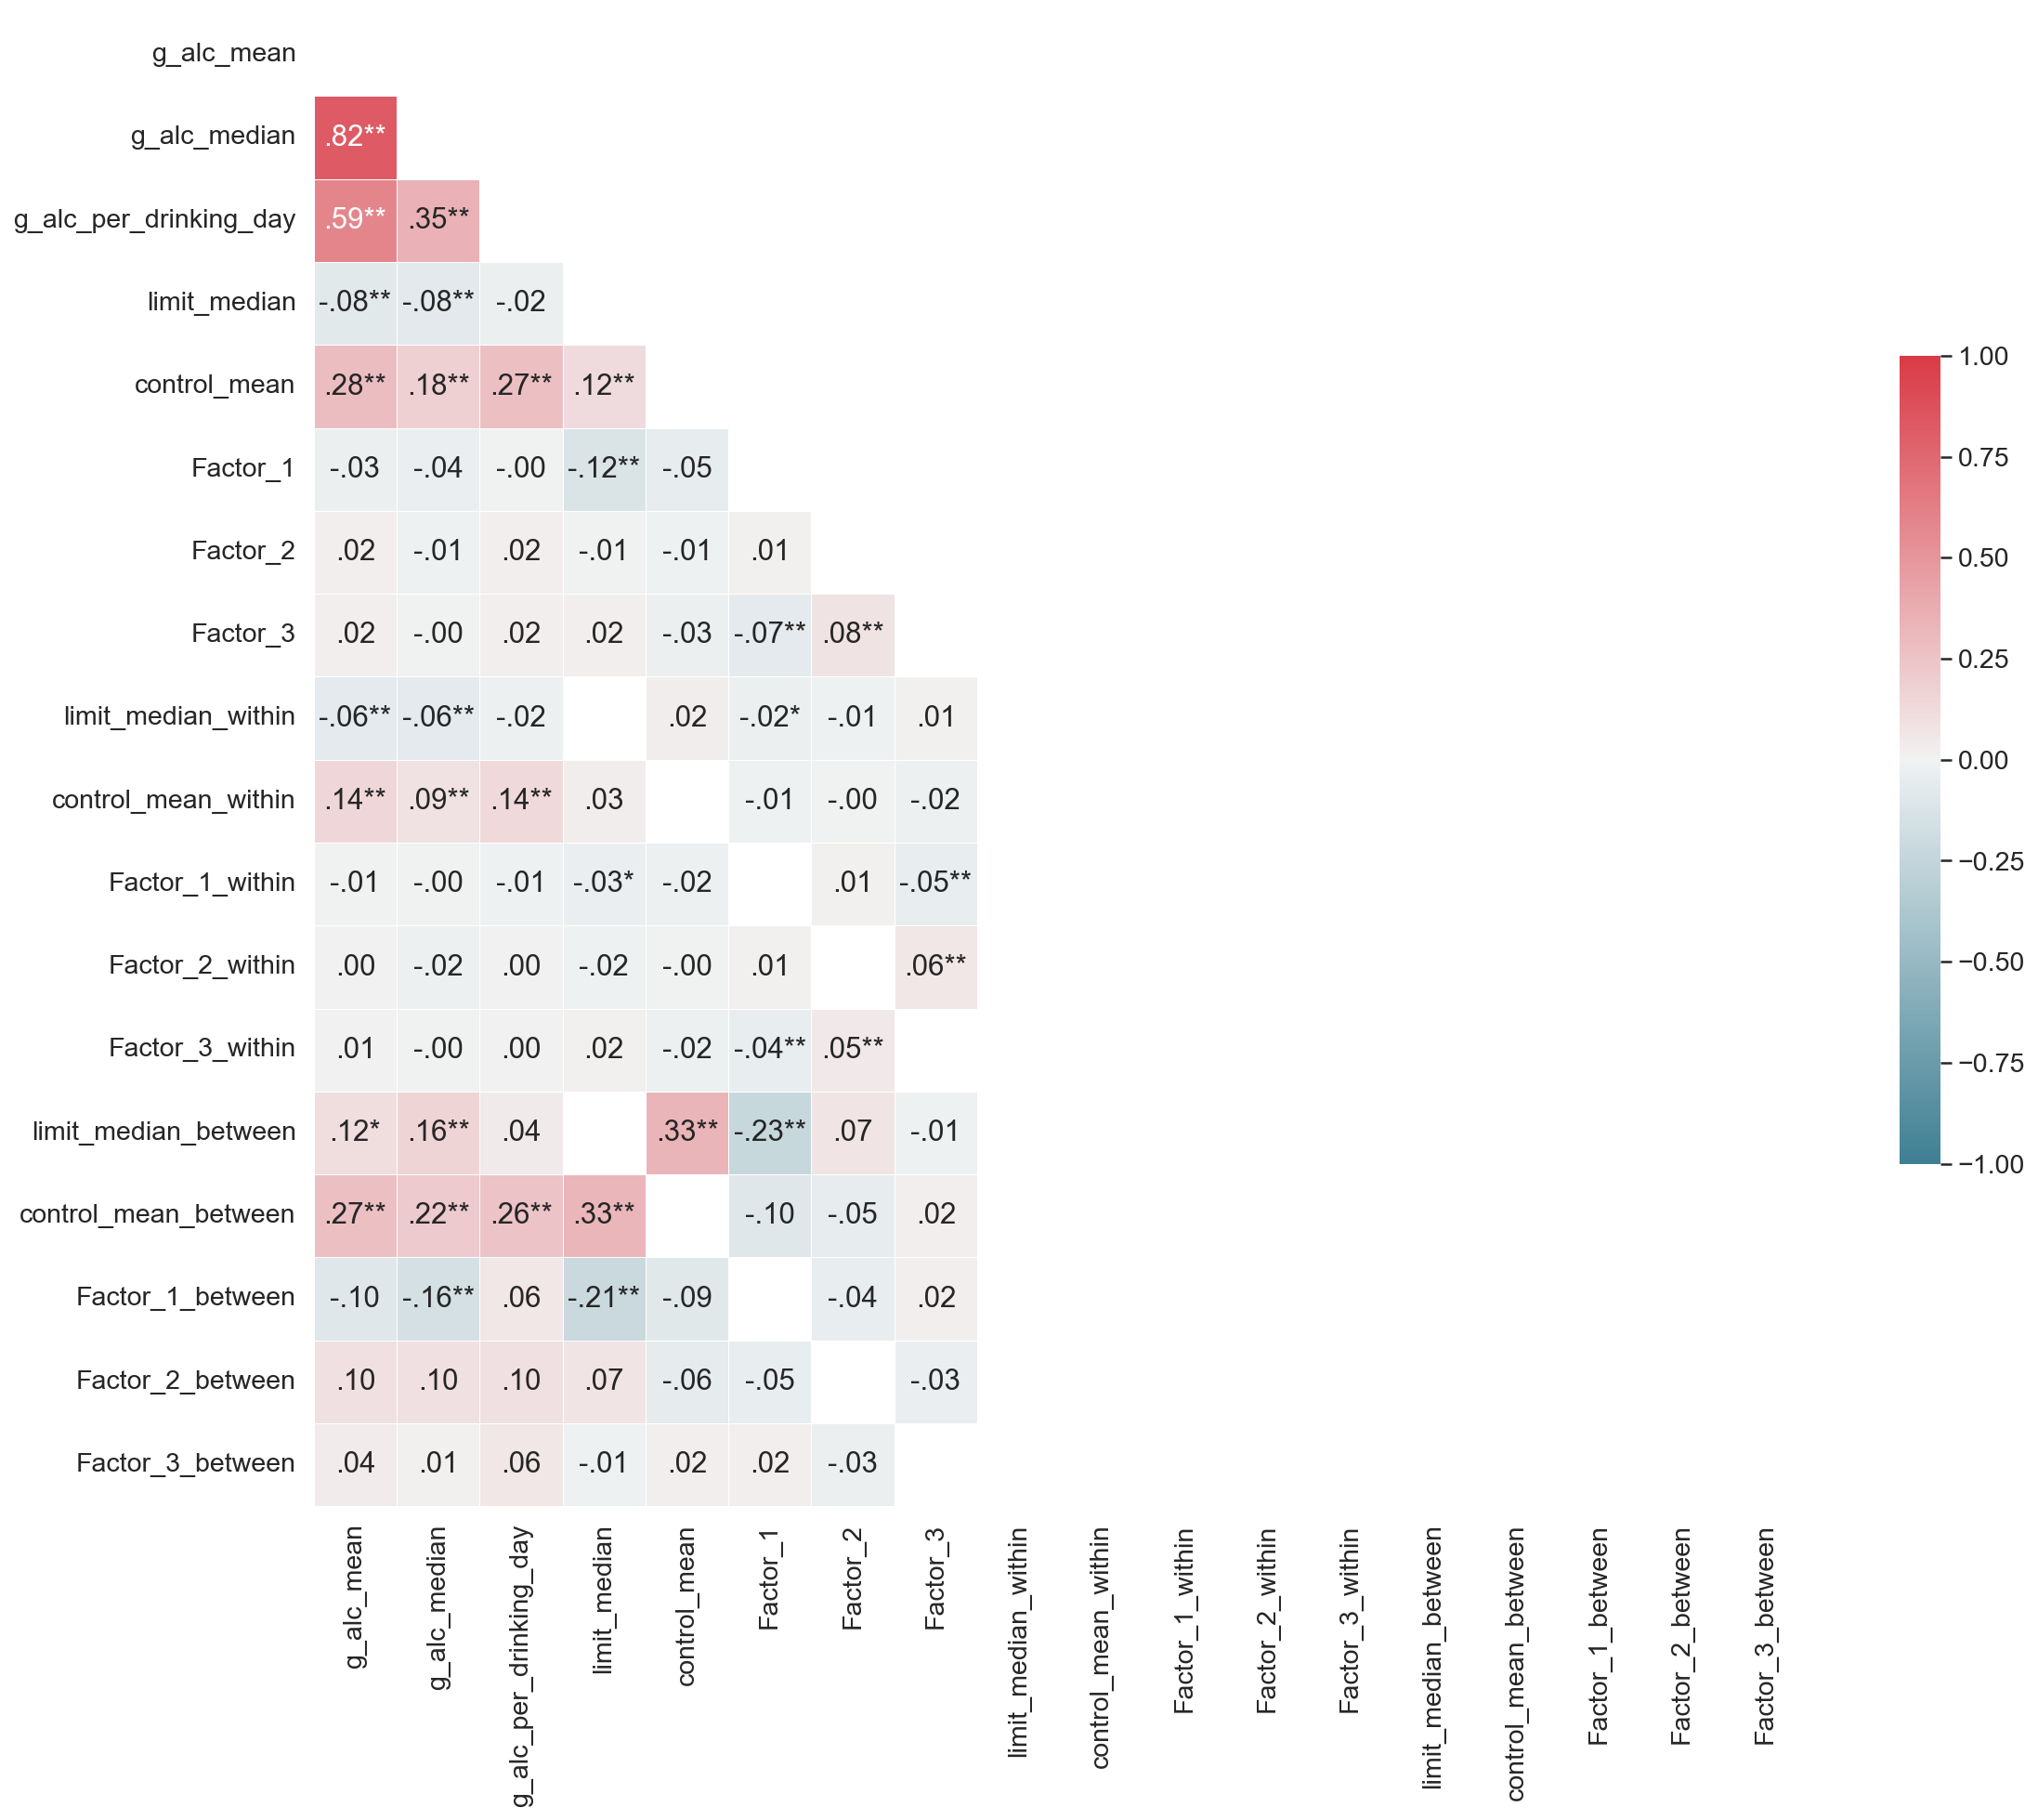

In [ ]:
cor2 = pd.concat([drinking, factor_scores.set_index('gbe_index')[['participant','Factor_1','Factor_2','Factor_3']]], axis = 1).dropna()
cor3 = cor2.set_index('participant')
columns = ['limit_median','control_mean','Factor_1','Factor_2','Factor_3']
cor3 = decompose_within_between(cor3.reset_index(),columns = columns, result='both', drop = False).set_index('participant')
cor3 = (cor3-cor3.mean())/cor3.std()
correlation_matrix(cor3.reset_index(), corr_func = lmer_within_between, size = (18,16))

#### Intention and consumption

In [ ]:
cor2 = pd.concat([drinking, factor_scores.set_index('gbe_index')[['participant','Factor_1','Factor_2','Factor_3']]], axis = 1).dropna()
cor3_d = cor2.set_index('participant')
columns = ['limit_median','control_mean','Factor_1','Factor_2','Factor_3']
cor3_d = decompose_within_between(cor3_d.reset_index(),columns = columns, result='both', drop = False).set_index('participant')

In [ ]:
lmer_within_between('limit_median_within', 'g_alc_median',cor3.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_median ~ limit_median_within + limit_median_between + (1 |  
    participant)
   Data: df

REML criterion at convergence: 4011.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5773 -0.4162 -0.0764  0.4080  8.5080 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6242   0.7901  
 Residual                0.3070   0.5541  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            -0.06284    0.05079  268.94559  -1.237 0.217018    
limit_median_within    -0.06462    0.01242 1731.20797  -5.203  2.2e-07 ***
limit_median_between    0.16193    0.04861  280.74080   3.331 0.000981 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) lmt_mdn_w
lmt_mdn_wth  0.000          
lmt

(-0.06462042192089323, 2.1954461040709882e-07)

<AxesSubplot:xlabel='limit_median_between', ylabel='g_alc_median'>

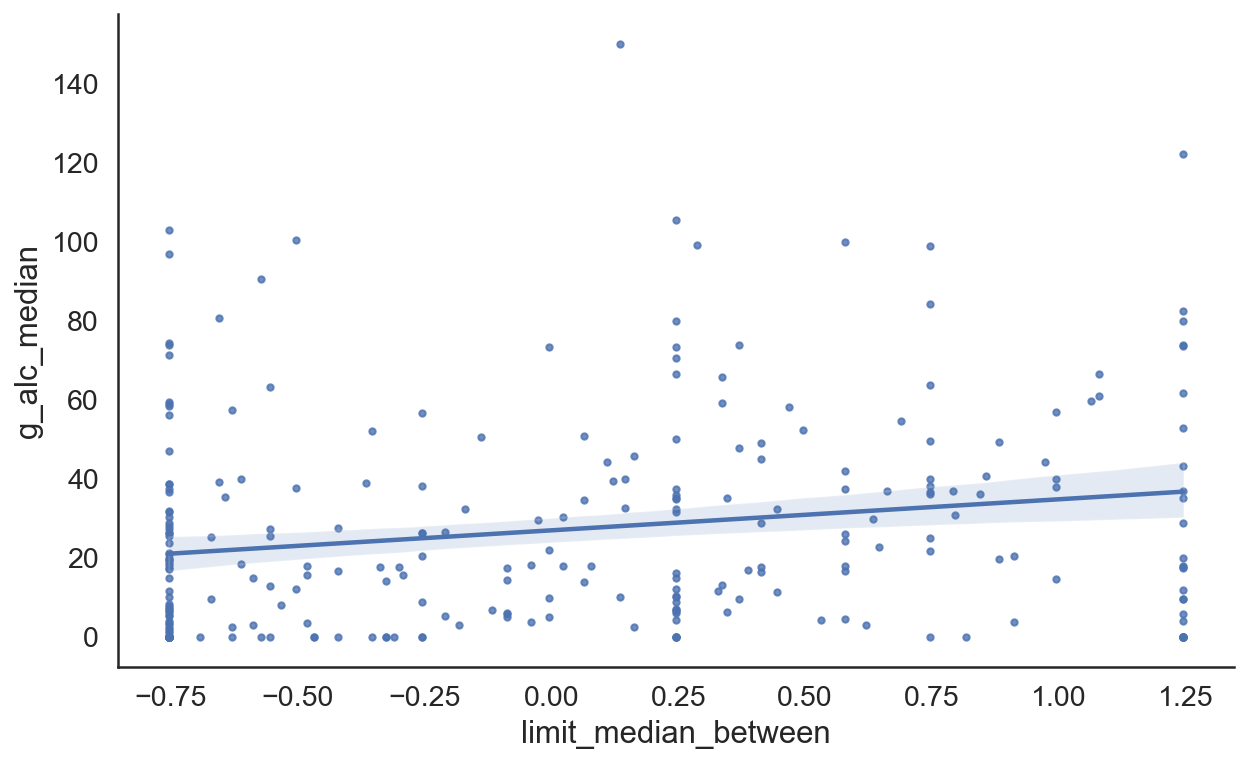

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'limit_median_between', y = 'g_alc_median', data = cor3_d.groupby('participant').mean(),scatter_kws={'s':10})

<AxesSubplot:xlabel='limit_median_within', ylabel='g_alc_median'>

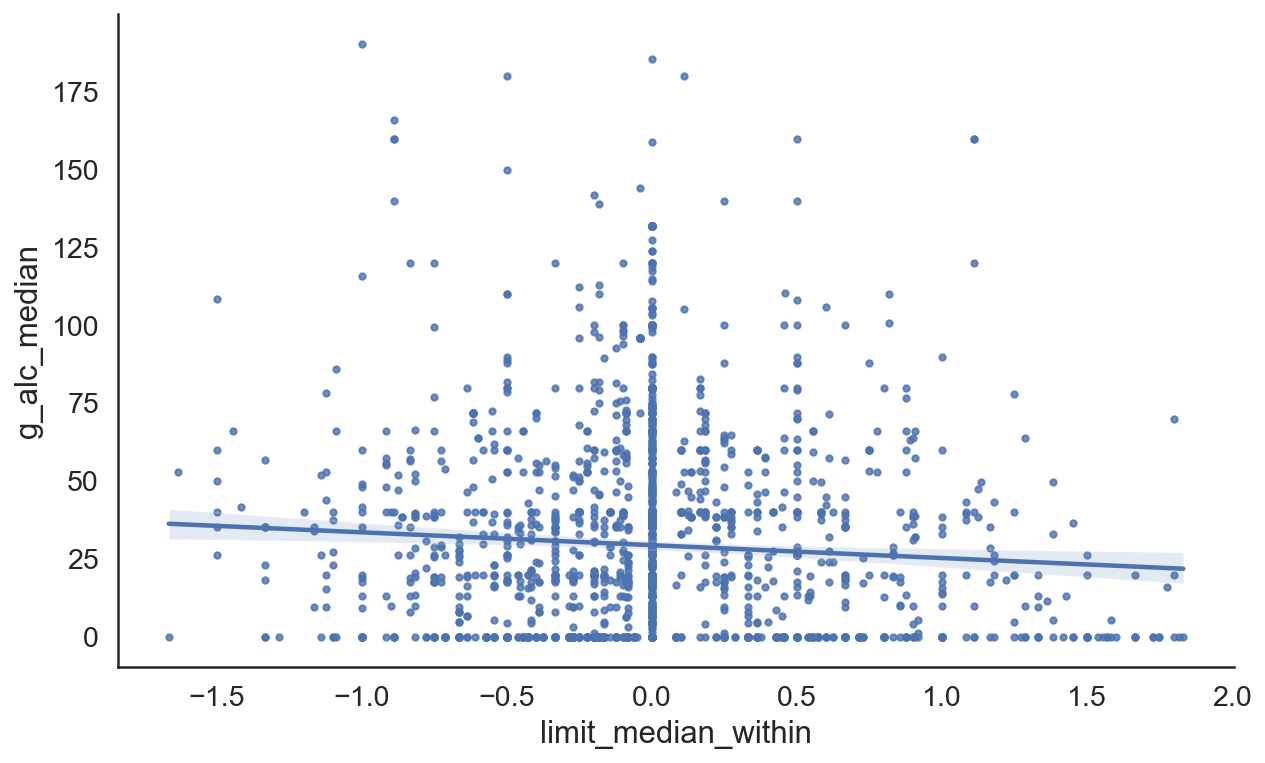

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'limit_median_within', y = 'g_alc_median', data = cor3_d,scatter_kws={'s':10})

Text(0.5, 0, 'limit median')

<Figure size 720x432 with 0 Axes>

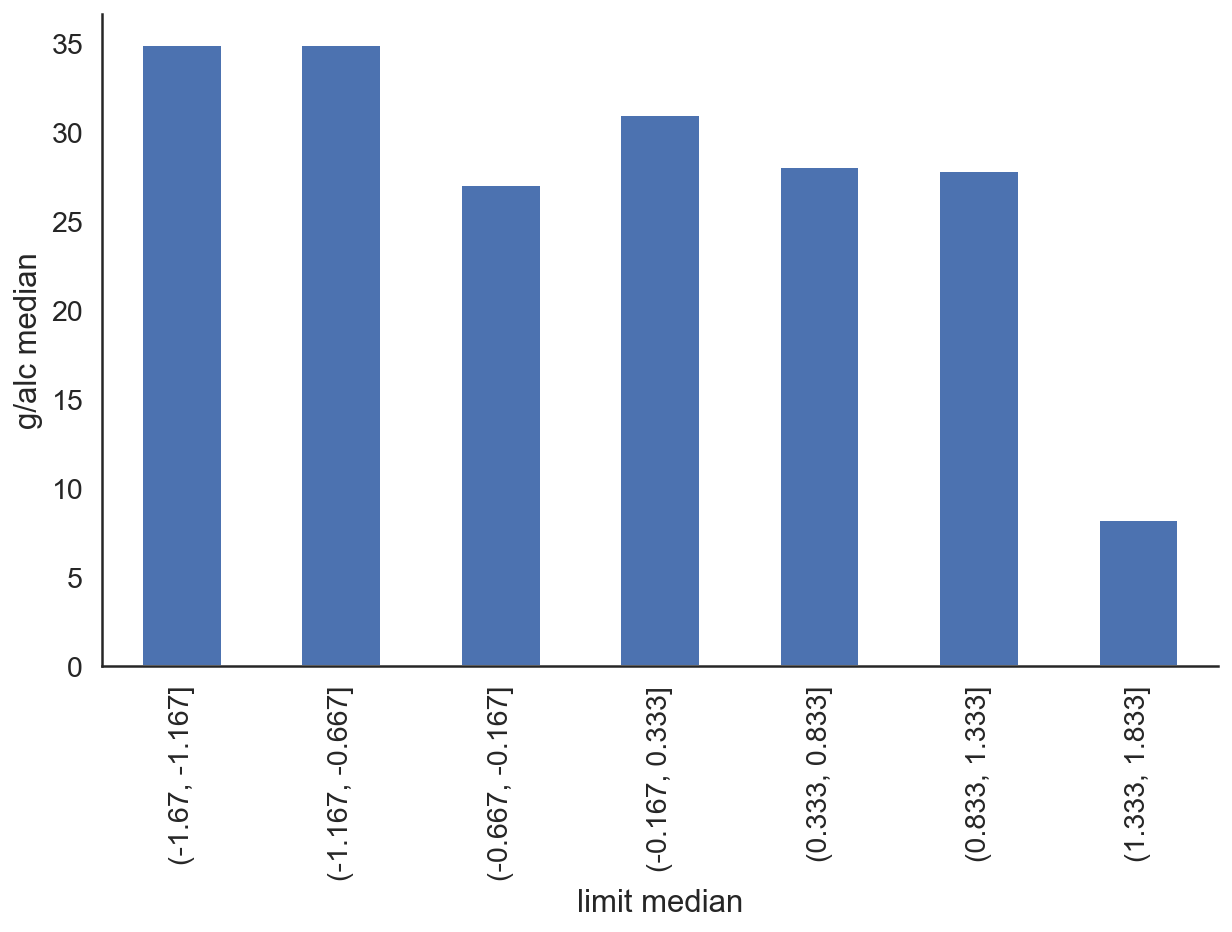

In [ ]:
plt.figure(figsize=(10,6))
cor3_d['limit_binned'] = pd.cut(cor3_d.limit_median_within, 7)
ax = cor3_d.groupby('limit_binned').g_alc_median.agg([np.mean, np.std]).reset_index().plot.bar(x = 'limit_binned', y = 'mean',figsize=(10,6), legend = False)
ax.set_ylabel('g/alc median')
ax.set_xlabel('limit median')


#### Perceived control and consumption

In [ ]:
lmer_within_between('control_mean_within', 'g_alc_median',cor3.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_median ~ control_mean_within + control_mean_between + (1 |  
    participant)
   Data: df

REML criterion at convergence: 3979.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8557 -0.4350 -0.0394  0.4008  8.9800 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6075   0.7794  
 Residual                0.3025   0.5500  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            -0.06122    0.05012  269.32090  -1.222    0.223    
control_mean_within     0.08936    0.01233 1731.59623   7.247 6.38e-13 ***
control_mean_between    0.21632    0.05021  269.32380   4.308 2.31e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) cntrl_mn_w
cntrl_mn_wt  0.000           
c

(0.08935708701710784, 6.384905946129546e-13)

<AxesSubplot:xlabel='control_mean_between', ylabel='g_alc_median'>

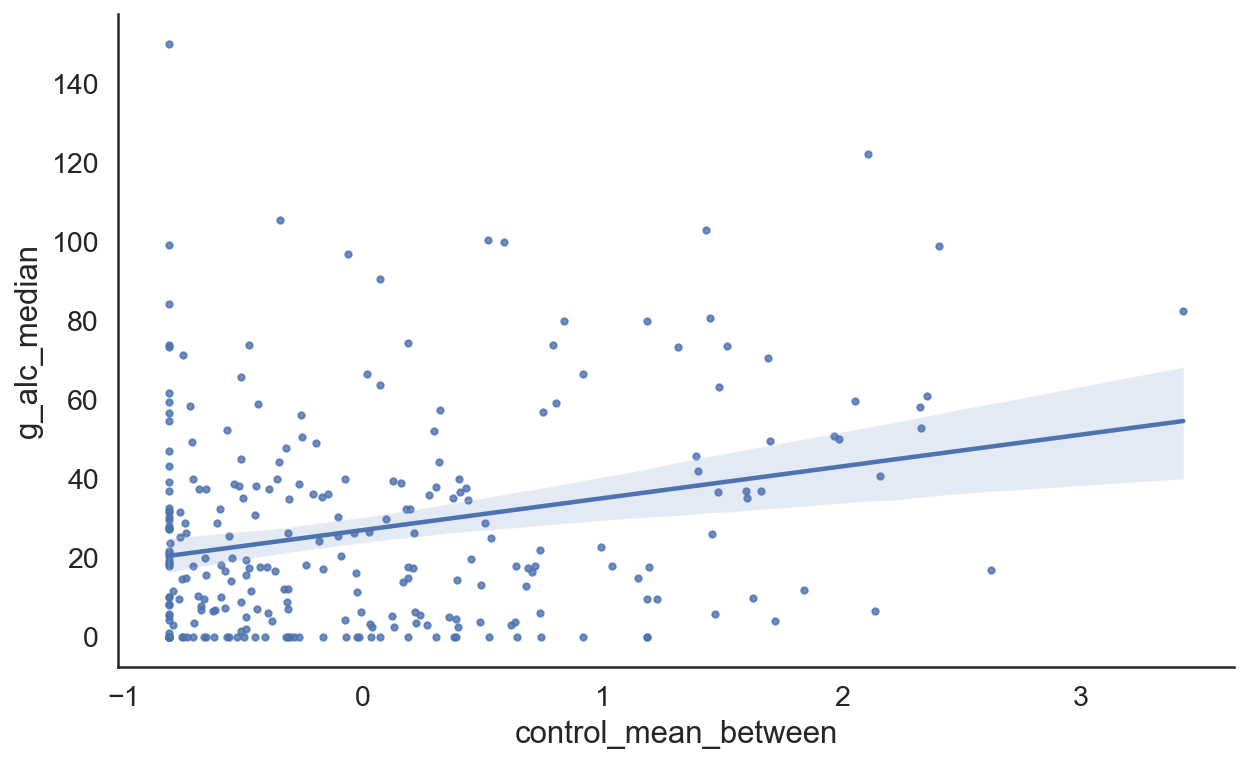

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'control_mean_between', y = 'g_alc_median', data = cor3_d.groupby('participant').mean(),scatter_kws={'s':10})

<AxesSubplot:xlabel='control_mean_within', ylabel='g_alc_median'>

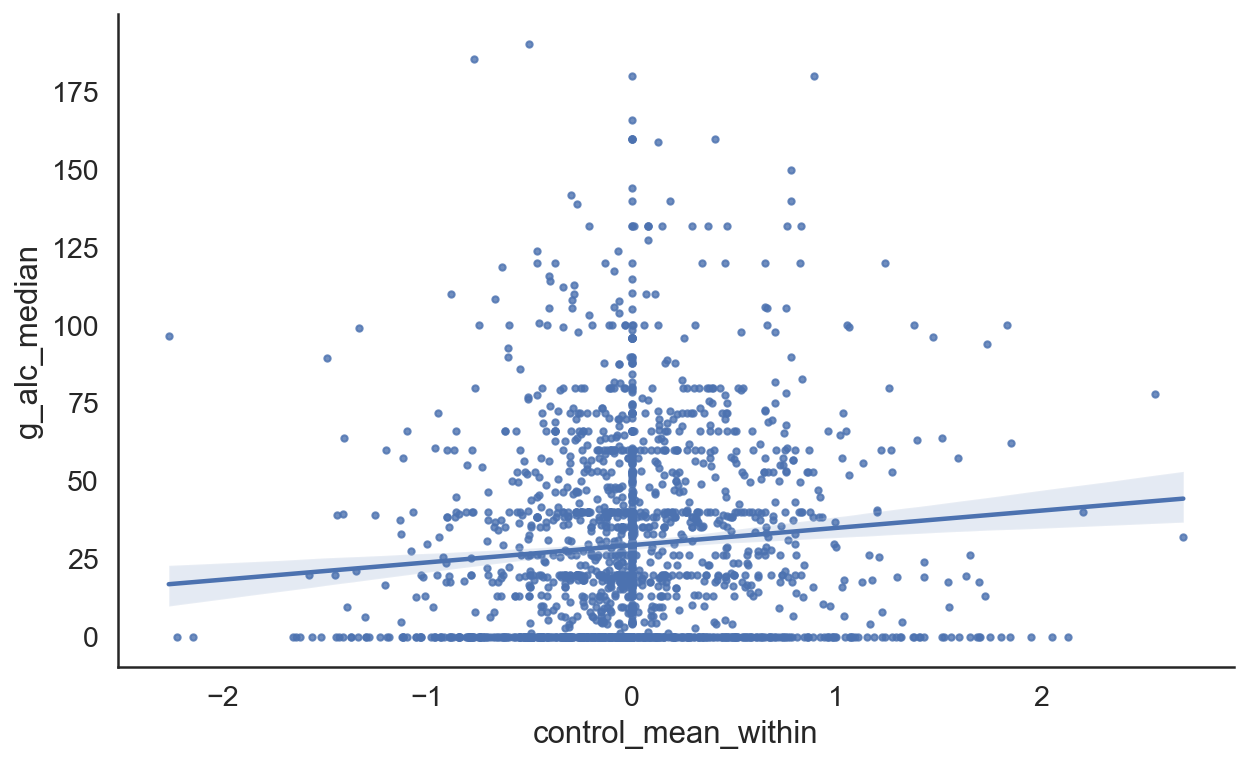

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'control_mean_within', y = 'g_alc_median', data = cor3_d,scatter_kws={'s':10})

Text(0.5, 0, 'control')

<Figure size 720x432 with 0 Axes>

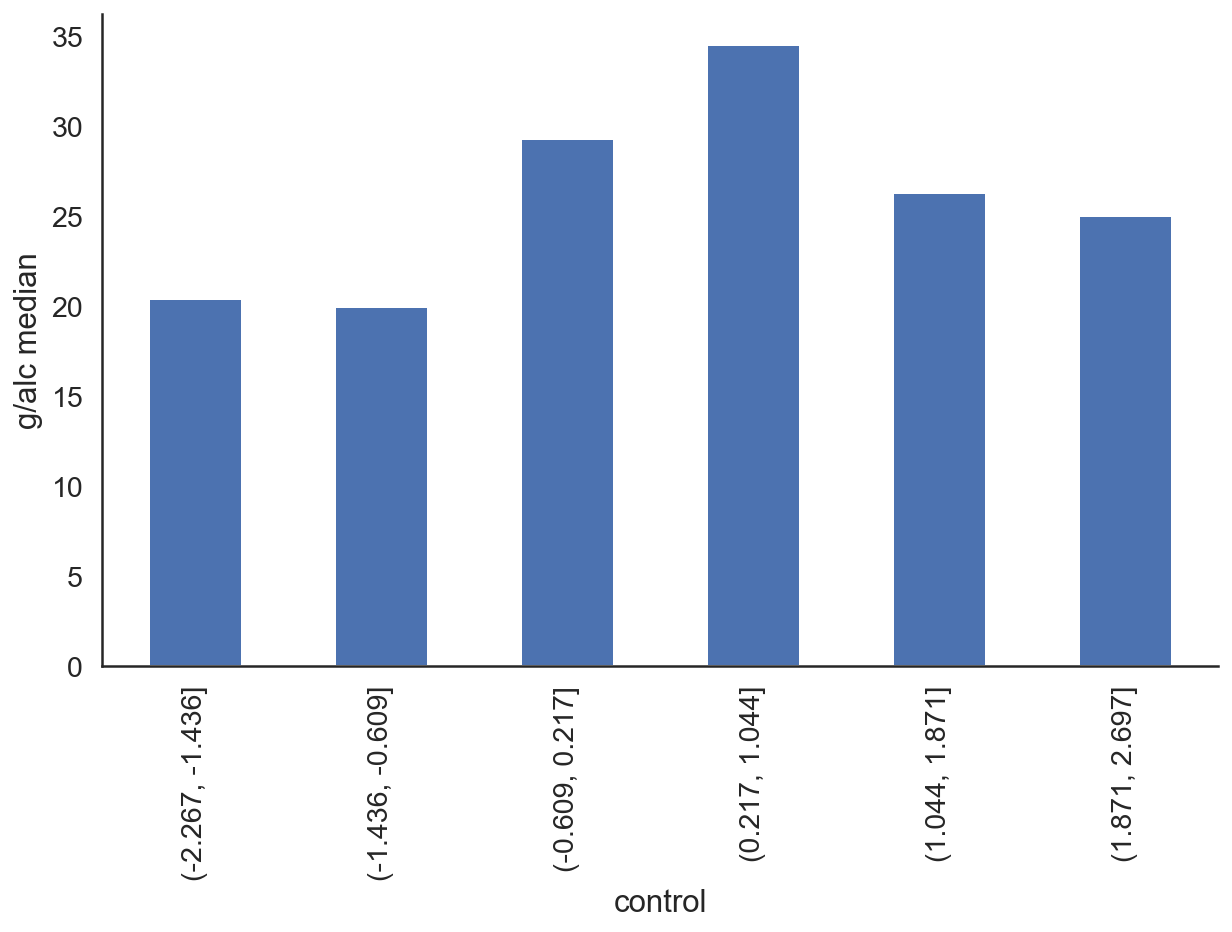

In [ ]:
plt.figure(figsize=(10,6))
cor3_d['limit_binned'] = pd.cut(cor3_d.control_mean_within, 6)
ax = cor3_d.groupby('limit_binned').g_alc_median.agg([np.mean, np.std]).reset_index().plot.bar(x = 'limit_binned', y = 'mean',figsize=(10,6), legend = False)
ax.set_ylabel('g/alc median')
ax.set_xlabel('control')

#### Cognitive control and intention

In [ ]:
lmer_within_between('Factor_1_within', 'limit_median',cor3.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: limit_median ~ Factor_1_within + Factor_1_between + (1 | participant)
   Data: df

REML criterion at convergence: 4599.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9623 -0.4618 -0.0844  0.3217  3.3399 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.5311   0.7287  
 Residual                0.4386   0.6623  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         0.01041    0.04815  256.06604   0.216   0.8289    
Factor_1_within    -0.03298    0.01485 1722.68151  -2.222   0.0264 *  
Factor_1_between   -0.21409    0.04742  255.99103  -4.515 9.68e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) Fctr_1_w
Fctr_1_wthn 0.000          
Fctr_1_btwn 0.027  0.000   


(-0.032982664568762664, 0.02644276000543407)

<AxesSubplot:xlabel='Factor_1_between', ylabel='limit_median'>

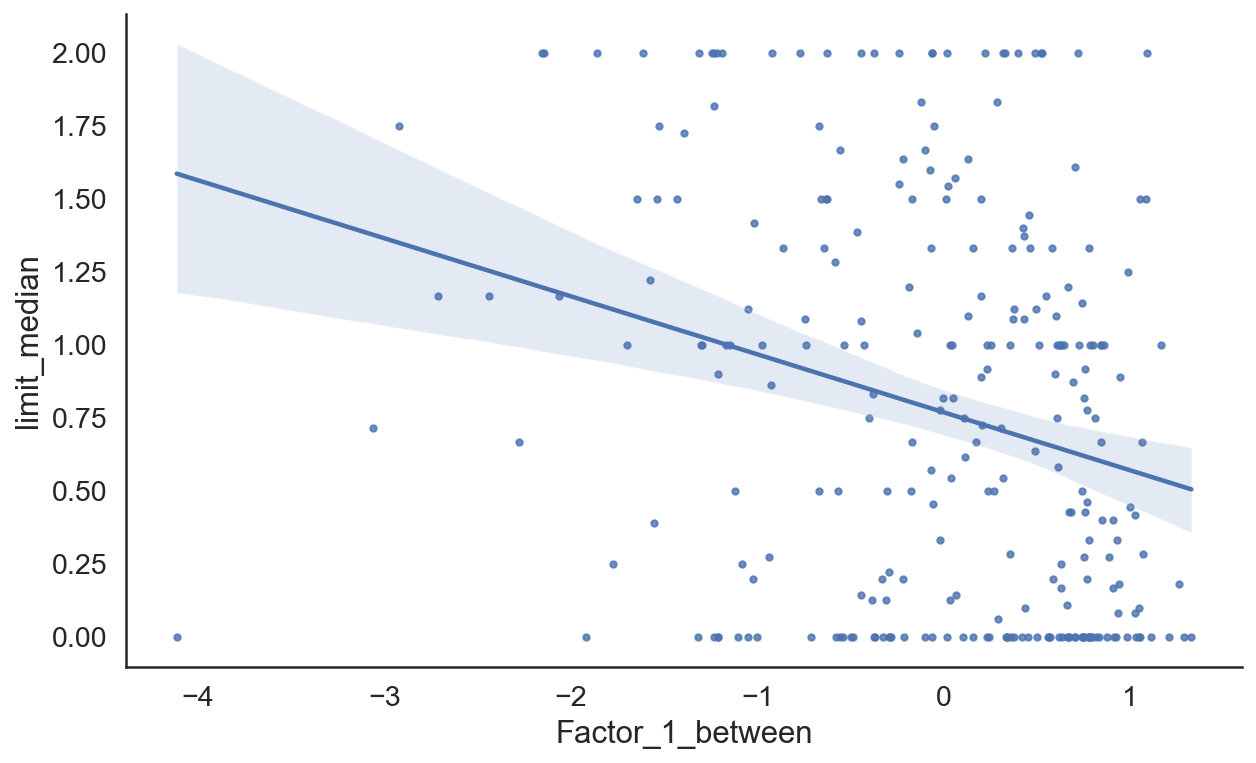

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'Factor_1_between', y = 'limit_median', data = cor3_d.groupby('participant').mean(),scatter_kws={'s':10})

<AxesSubplot:xlabel='Factor_1_within', ylabel='limit_median'>

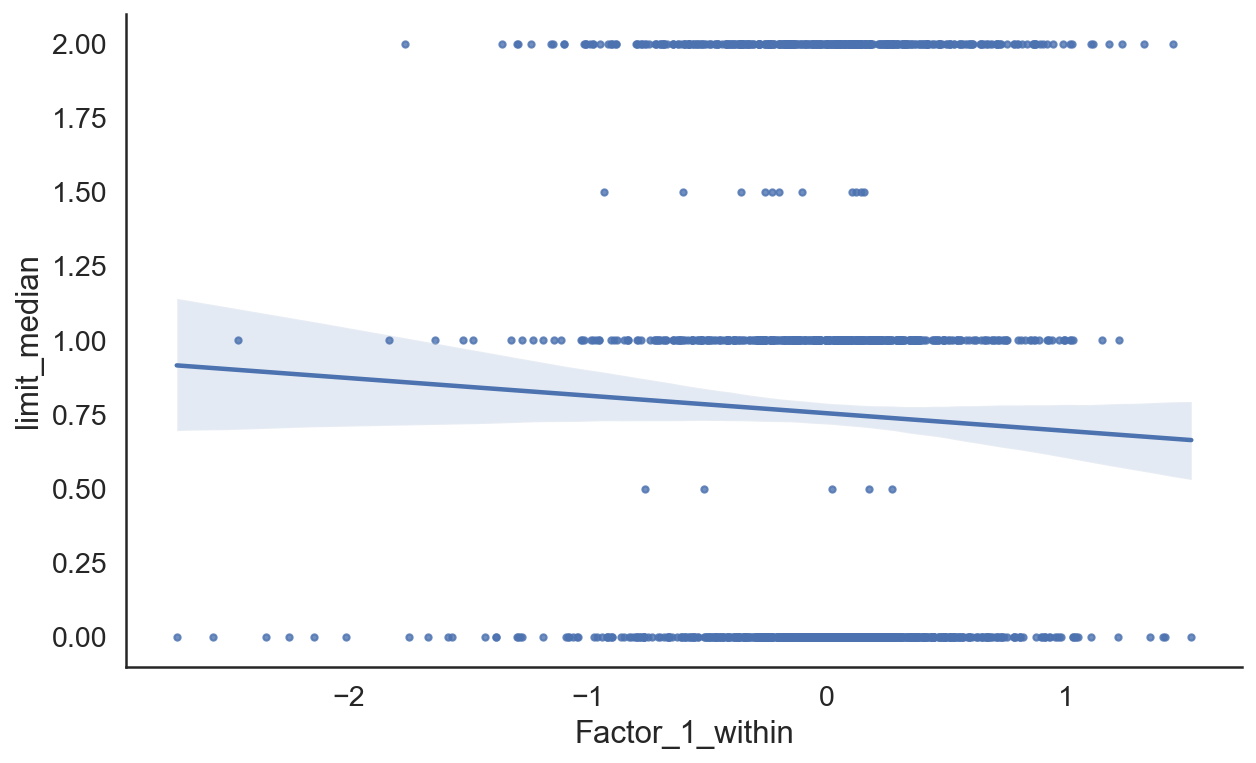

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'Factor_1_within', y = 'limit_median', data = cor3_d,scatter_kws={'s':10})

Text(0.5, 0, 'Factor 1 within')

<Figure size 720x432 with 0 Axes>

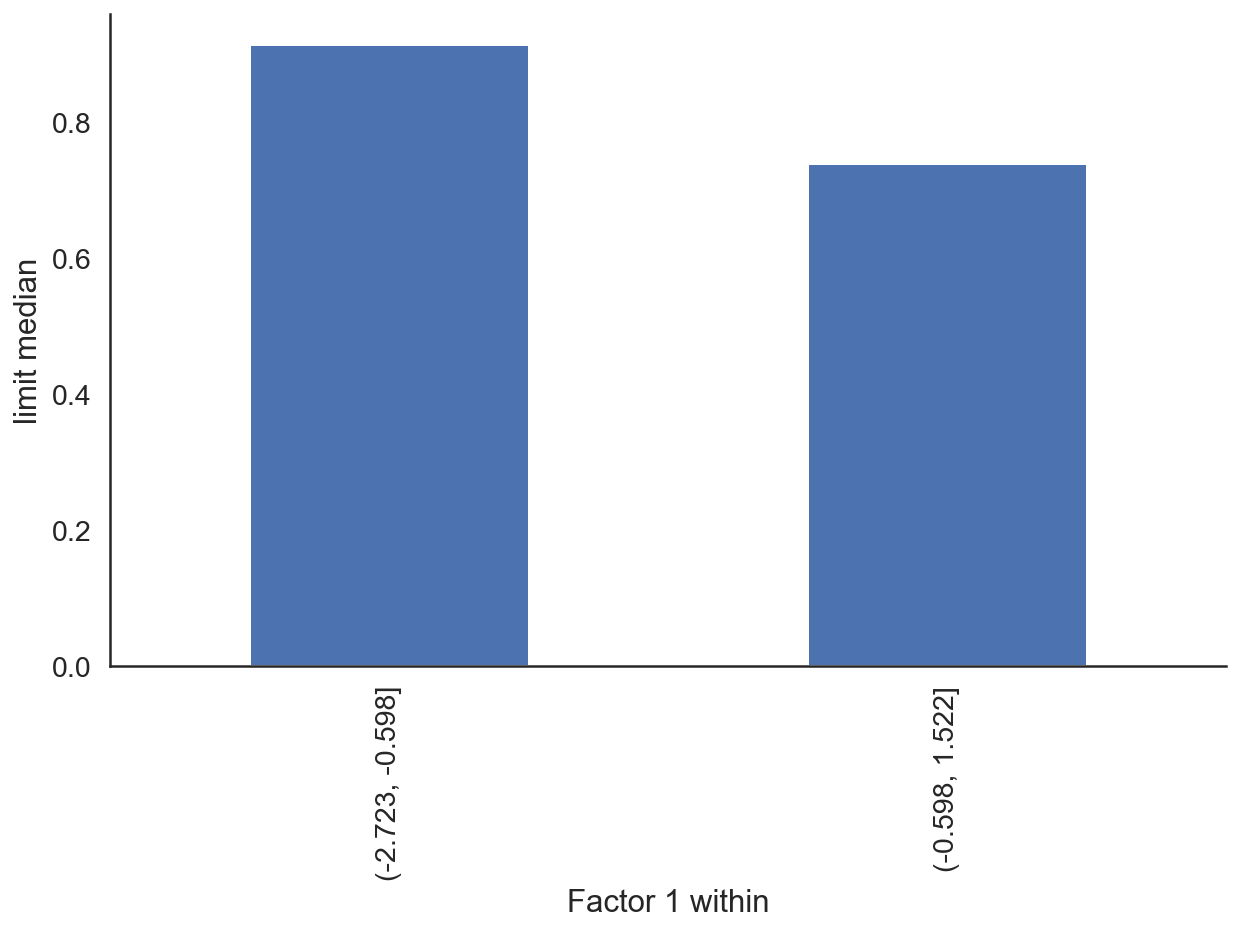

In [ ]:
plt.figure(figsize=(10,6))
cor3_d['limit_binned'] = pd.cut(cor3_d.Factor_1_within, 2)
ax = cor3_d.groupby('limit_binned').limit_median.agg([np.mean, np.std]).reset_index().plot.bar(x = 'limit_binned', y = 'mean',figsize=(10,6), legend = False)
ax.set_ylabel('limit median')
ax.set_xlabel('Factor 1 within')

#### Cognitive control and perceived control

In [ ]:
lmer_within_between('Factor_1_within', 'control_mean',cor3.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: control_mean ~ Factor_1_within + Factor_1_between + (1 | participant)
   Data: df

REML criterion at convergence: 4031.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9324 -0.4686 -0.0925  0.3895  4.8778 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6688   0.8178  
 Residual                0.3076   0.5546  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)       6.554e-03  5.243e-02  2.668e+02   0.125   0.9006  
Factor_1_within  -1.566e-02  1.243e-02  1.729e+03  -1.260   0.2078  
Factor_1_between -9.226e-02  5.165e-02  2.663e+02  -1.786   0.0752 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) Fctr_1_w
Fctr_1_wthn 0.000          
Fctr_1_btwn 0.026  0.000   


(-0.015664204055465654, 0.20784026056862412)

#### Cognitive control and consumption

In [ ]:
lmer_within_between('Factor_1_within', 'g_alc_median',cor3.reset_index(), model_output = True)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_median ~ Factor_1_within + Factor_1_between + (1 | participant)
   Data: df

REML criterion at convergence: 4039.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5510 -0.3963 -0.0816  0.4134  8.6850 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.6280   0.7924  
 Residual                0.3117   0.5583  
Number of obs: 1991, groups:  participant, 267

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)      -6.319e-02  5.096e-02  2.704e+02  -1.240  0.21607   
Factor_1_within  -7.825e-04  1.251e-02  1.733e+03  -0.063  0.95015   
Factor_1_between -1.587e-01  5.020e-02  2.699e+02  -3.161  0.00175 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) Fctr_1_w
Fctr_1_wthn 0.000          
Fctr_1_btwn 0.026  0.000   


(-0.0007824690113006357, 0.9501516726816106)

<AxesSubplot:xlabel='Factor_1_between', ylabel='g_alc_median'>

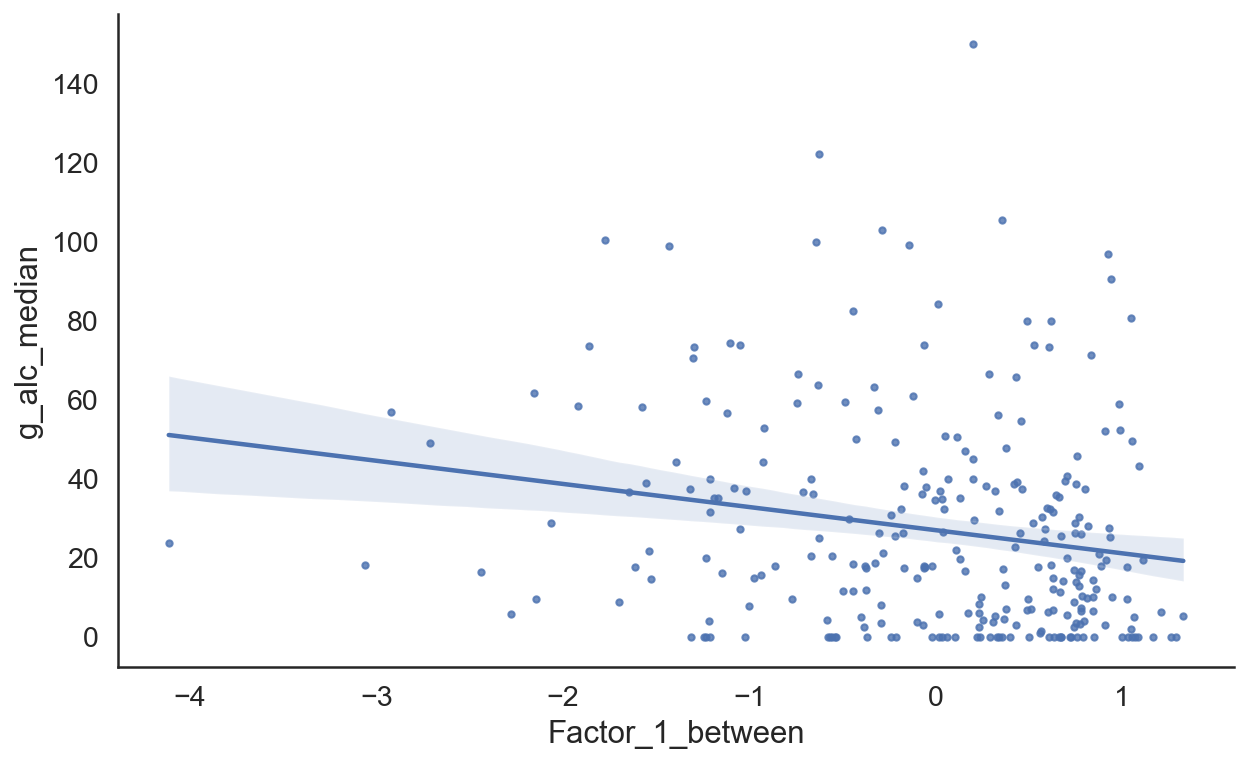

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'Factor_1_between', y = 'g_alc_median', data = cor3_d.groupby('participant').mean(),scatter_kws={'s':10})

In [ ]:
cor4 = cor3.reset_index()

In [ ]:
stats.pearsonr(cor4['Factor_1'],cor4['Factor_3'])

NameError: name 'stats' is not defined

In [ ]:
%%R -i cor4
require(lmerTest)
m <- lmer(Factor_3 ~ Factor_1 + (1|participant), data = cor4)
summary(m)

#### Intention as factor

In [ ]:
cor2 = pd.concat([drinking, factor_scores.set_index('gbe_index')[['participant','session_number','Factor_1','Factor_2','Factor_3']]], axis = 1).dropna()

In [ ]:
%%R -i cor2
require(lmerTest)
m <- lmer(Factor_1 ~ as.factor(limit_median) + (1|participant), data = cor2)
summary(m)

In [ ]:
%%R -i cor2
require(lmerTest)
m <- lmer(g_alc_median ~ as.factor(limit_median) + (1|participant), data = cor2)
summary(m)

### Cross-sectional effects based on longitudinal data

In [ ]:
#factor_scores = factor_scores.set_index('gbe_index').filter(like='Factor')
cor2 = pd.concat([drinking, factor_scores.set_index('gbe_index')[['participant','Factor_1','Factor_2','Factor_3']]], axis = 1).dropna().groupby('participant').mean().reset_index()

In [ ]:
correlation_matrix(cor2)

In [ ]:
from scipy import stats
stats.pearsonr(cor2['Factor_1'], cor2['g_alc_median'])

### Average longitudinal correlation per participant

In [ ]:
cor2 = pd.concat([drinking, factor_scores.set_index('gbe_index')[['participant','Factor_1','Factor_2','Factor_3']]], axis = 1).dropna()

In [ ]:
cor2.groupby('participant').corr().reset_index().groupby('level_1').mean()

## Hypotheses

- L1. Changes in inhibitory control relate negatively to real-life changes in drinking.
- L2. Changes in risk aversion for gains relate negatively to real-life changes in drinking.
- L3. Changes in risk aversion for losses relate positively to real-life changes in drinking.
- L4. Changes in loss aversion relate negatively to real-life changes in drinking.
- L5. Changes in sampling biases relate negatively to real-life changes in drinking.
- L6. Between-subject differences in working memory moderate the effects of changes in
inhibitory control and risk aversion on changes in drinking. Specifically, the expected positive and negative relationships between changes in inhibitory control as well as in risk aversion (see L1, L2, and L3) and drinking are stronger when working memory is low.
- L7. Between-subject differences in working memory moderate the effects of stress on drinking such that the positive relationship between stress and drinking is stronger when working memory is low.

### ToDo
- Decompose into between- and within-participant effects
- Check pre-registered model (interaction with WM)